In [ ]:
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import pandas as pd
import json
import os

import powerlaw
from matplotlib.lines import Line2D
import df2img
from datetime import datetime , timedelta
import scipy as sci
import statsmodels.formula.api as smf
import statsmodels.api as st
import matplotlib as mpl
import matplotlib.colors as mcolors
import seaborn as sns

## Data

In [ ]:
#timeframe for alignment
start_time = '2021-09-23 10:40:00'
end_time = '2023-10-18 16:10:00'

path_for_WeiRu = 'gdrive/My Drive/pool and CEX data'
def df_setting(df,T,label,token_0,token_1,timeframe_align):

    df['return'] = df['close'].apply(np.log).diff()
    df['dT'] = T
    df['token'] = f'{token_0} & {token_1}'
    if timeframe_align == True:
        df = df[(df.index>=start_time)&(df.index<=end_time)].copy()
    else:
        label+= ' all'
    df['label'] =label
    return df
#pool
token_0 = 'WETH'
token_1_list =['USDC','USDT','DAI']
time_list = ['10min','1H']
label_dic = {'arb_3000':'arb_3000','arb_500':'arb_500','m_3000':'mainnet_3000','m_500':'mainnet_500'}
df_list =[]
for key , value in label_dic.items():
    for token_1 in token_1_list:
        for T in time_list:
            try:
                df=  pd.read_csv(f'{path_for_WeiRu}/organized data/{token_0}_{token_1}_{value}/{token_0}_{token_1}_{key}_{T}.csv'
                                 , index_col = 'datetime')[['close']]
                df.index = pd.to_datetime(df.index)
                df = df_setting(df,T,key,token_0,token_1,timeframe_align=True)
                df_list.append(df)
            except FileNotFoundError:
                print(f'no {key} {token_0} & {token_1} {T}')
                continue
token_1 = 'USD'
label_list = ['Binance','coinbase']
df_list_cb =[]
for label in label_list:
  if label=='Binance':
    list_to_append = df_list
  else:
    list_to_append = df_list_cb
  for token_0 in ['ETH' , 'BTC']:
      for T in time_list:
          try:
              df=  pd.read_csv(f'{path_for_WeiRu}/Binance/{token_0}/{token_0}_{token_1}_{T}.csv' , index_col = 'datetime')
              df.index = pd.to_datetime(df.index)
              df1 = df_setting(df,T,label,token_0,token_1,timeframe_align=True)
              list_to_append.append(df1)

              if token_0 == 'ETH':
                  df2 = df_setting(df,T,label,token_0,token_1,timeframe_align=False)
                  list_to_append.append(df2)

          except FileNotFoundError:
              print(f'no {label} {token_0} & {token_1} {T}')

            continue

In [ ]:
#trad fin data
df_list_trad =[]
def spy_eur(s):
    if s=='SPY':
        return 'SPY & USD'
    elif s == 'EUR':
        return 'EUR & USD'

df_trad =pd.read_csv(f'{path_for_WeiRu}/SPY_EUR_over60min.csv',index_col='datetime')
df_trad.index = pd.to_datetime(df_trad.index)
df_trad.drop(columns='Unnamed: 0',axis=1,inplace = True)
df_trad['dT']='1H'
df_trad['token']=df_trad.apply(lambda r: spy_eur(r.label) ,axis=1)

df_trad_partial =df_trad[(df_trad.index>= start_time)&(df_trad.index<=end_time)].copy()
df_trad['label']= df_trad.apply(lambda r: r.label+' all' ,axis=1)

#note that each dataframe contains both EUR and SPY!!
df_list_trad.append(df_trad_partial[['close','return','dT','label','token']])
df_list_trad.append(df_trad[['close','return','dT','label','token']])
temp = []
# sparate EUR and SPY
for df in df_list_trad:
    lab_array = df.label.unique()
    for lab in lab_array:
        temp.append(df[df.label==lab])
df_list_trad = temp

#put all together
df_all = pd.concat(df_list+df_list_trad)

In [ ]:
#color setting


colormap = mpl.colormaps.get_cmap('turbo')
colors = [colormap(i) for i in range(colormap.N)]

hex_colors = [mpl.colors.rgb2hex(color) for color in colors]

## Color setting

In [ ]:
#color setting


colormap = mpl.colormaps.get_cmap('turbo')
colors = [colormap(i) for i in range(colormap.N)]

hex_colors = [mpl.colors.rgb2hex(color) for color in colors]
color_list = ['#10A37F', '#147960', '#024736', '#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0',
              '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000',
              '#000075', '#808080', '#00008B', '#000000', '#ffd8b1', '#fffac8', '#aaffc3']
prop_cycle = plt.rcParams['axes.prop_cycle']
c_cycle = prop_cycle.by_key()['color']

## Functions

In [ ]:
def std_array(array):
    std_list=[]
    N = len(array)
    var = np.var(array)
    m = np.mean(array)
    for x in array:
        var_new = (N*var - x**2)/(N-1) - (N+1)/(N-1) * m**2 + 2*m*x/(N-1)
        std_list.append( np.sqrt(var_new) )
    return np.array(std_list)
# use usal std
def normalize(array,med_shift = True):
    if med_shift:
        shift = np.median(array)
    else:
        shift = np.mean(array)
    return (array - shift )/ np.std(array)
#std_array(array)
def plot_pdf(array,norm=True,med_shift=True):

    if norm :
        array = normalize(array,med_shift)
        shift = 0
        a = 1
    else:
        a = np.std(array)
        if med_shift:
            shift = np.median(array)
        else:
            shift = np.mean(array)


    if len(array) < 10000:
        n = 11
        m = 6
    else:
        n = 21
        m = 11
    l = -5*a+shift
    r = 5*a+shift
    c_l = -2*a+shift
    c_r = 2*a+shift
    bin_m = np.linspace(c_l,c_r,60)

    bin_l = np.linspace(l,c_l,n)
    bin_r = np.linspace(c_r,r,n)
    bin_l = bin_l[bin_l !=c_l]
    bin_r = bin_r[bin_r != c_r]

    r_max=max(array)
    r_min=min(array)
    if r_max > r:
        bin_rr = np.linspace(r,max(array),m)
        bin_rr = bin_rr[bin_rr != r]
    else:
        bin_rr=[]
    if r_min < l:
        bin_ll = np.linspace(min(array),l,m)
        bin_ll = bin_ll[bin_ll !=l]
    else:
        bin_ll=[]

    bins = np.concatenate((bin_ll,bin_l,bin_m,bin_r,bin_rr ))

    return np.histogram( array  ,bins=bins,density=True );
def cdf_df(array,norm = True,med_shift=True):
    if norm == True:
        array = normalize(array,med_shift)
    value = np.sort(array)
    cdf = np.arange(1, len(array)+1) / (len(array))
    df = pd.DataFrame({'x': value, 'y': cdf})

    return df.drop_duplicates(['x'],keep='last') #if some value is repeated in data_array, keep last

def cdf_modify(x,y,shift):
    if x>=0:
        if y ==1:
            return -100
        else:
            return np.log(1-y)
    if x <0:
        return np.log(y) +shift


def shiftlogcdf_df(array):
    df = cdf_df(array,norm=False)

    y_r = df[df.x>=0].values[0,1]
    y_l= df[df.x < 0].values[-1,1]
    shift = np.log(1-y_r) -np.log( y_l)
    df.y =df.apply( lambda r: cdf_modify(r.x,r.y,shift) ,axis=1)

    return df
def rolling_window(df,dT):
    if dT =='1D':
        offset_increm = pd.DateOffset(days=1)
    elif dT == '1W':
         offset_increm = pd.DateOffset(weeks=1)
    elif dT == '1M':
         offset_increm = pd.DateOffset(months=1)
    time = df.index[0]
    basic_increm = df.index[1] - time
    time_list =[]
    price_list =[]
    return_list =[]
    scale_array = std_array(df['return'].values)
    while time + offset_increm <= df.index[-1]:
        close =df.xs(time).close
        new_close =df.xs(time +offset_increm).close
        r = np.log(new_close)-np.log(close)
        return_list.append(r)
        time_list.append(time)
        price_list.append(close)
        time += basic_increm
    dff = pd.DataFrame(data = { 'close': price_list,'return':return_list ,'dT':dT ,
                                'label':df.label[0],'token':df.token[0] },index =time_list )

    return dff

# for 24/7 data
def plot_acf(method_list=['none','abs'],df_all=df_all,time_list=['1H'],nlags=96,scale=False):
    ''' method_list: list of 'none', 'abs', 'square'   '''
    df = df_all[df_all.dT.isin(time_list)].copy()
    acf_dict = {}

    def scale_len(x,scale=False):
        if scale:
            return 1
        else:
            return np.sqrt(len(x))
    for k, method  in enumerate(method_list):
        if method== 'none':
            df_acf = df.groupby(['label','token','dT'])['return'].apply(lambda x :st.tsa.stattools.acf(x[1:],
                                                                            nlags=nlags,fft=False)*scale_len(x[1:]))
        elif method == 'abs':
            df_acf =df.groupby(['label','token','dT'])['return'].apply(lambda x :st.tsa.stattools.acf( np.abs(x[1:]),
                                                                            nlags=nlags,fft=False)*scale_len(x[1:]))
        elif method == 'square':
            df_acf = df.groupby(['label','token','dT'])['return'].apply(lambda x :st.tsa.stattools.acf( x[1:]**2,
                                                                            nlags=10,fft=False)*scale_len(x[1:]))

        df_acf = pd.DataFrame(dict(df_acf)).reset_index()
        df_acf = df_acf.rename(columns={'index':'Lags'})
        df_acf =df_acf.melt(id_vars='Lags',var_name=['label','token','dT'] )
        acf_dict[method] = df_acf
    return acf_dict
 def cor(a1,a2):
    return ((a1 - a1.mean() )@(a2 - a2.mean() ))/ (a1.std()*a2.std())

def plot_acf_2( dff,nlags=96):
    hour = pd.Timedelta('0 days 01:00:00')
    df = dff.copy()
    T_array = df.index
    df['abs return'] = df['return'].abs()
    df_acf = pd.DataFrame(columns=['Lags','return','shifted return','method'])
    R_product = []
    Lags = []
    R =[]
    absR=[]
    for t in T_array:
        # print the time per quarter
        if (t-df.index[0])/hour % (24*30*4)==0:
            print(t)
        for s in T_array[np.logical_and(T_array>=t ,T_array<= t+ nlags*hour)]:
            diff = (s-t)/hour
            Lags.append( int(diff) )
            R.append( ( df.loc[t,'return'], df.loc[s,'return'] ) )
            absR.append( (df.loc[t,'abs return'], df.loc[s,'abs return'] ) )
    R = np.array(R)
    absR = np.array(absR)
    df_acf['Lags'] = Lags + Lags
    df_acf['method'] = ['none' for i in range(len(Lags))] + ['abs' for i in range(len(Lags))]
    df_acf.loc[df_acf.method=='none','return'] = R[:,0]
    df_acf.loc[df_acf.method=='abs','return'] = absR[:,0]
    df_acf.loc[df_acf.method=='none','shifted return'] = R[:,1]
    df_acf.loc[df_acf.method=='abs','shifted return'] = absR[:,1]

    df_acf=df_acf.groupby(['method','Lags']).apply(lambda r: pd.Series(
                      {'value': cor(r['return'],r['shifted return'] )/np.sqrt(len(r)) }) ).reset_index()
    df_acf['label']=df.label[0]
    df_acf['dT']='1H'
    df_acf['token'] = df.token[0]
    return df_acf

def cc(pool_label,pool_token,dT,lag):
    cex_return = df_all[ (df_all.label == 'Binance') &( df_all.token == 'ETH & USD' )& (df_all.dT == dT)]['return'].values
    pool_return = df_all[ (df_all.label == pool_label) &( df_all.token == pool_token )& (df_all.dT == dT)]['return'].values
    return np.arange(lag) , st.tsa.stattools.ccf(pool_return,cex_return ,nlags= lag), st.tsa.stattools.ccf(cex_return,pool_return,nlags= lag)

def resample_close(x:pd.DataFrame,rPeriod='1D'):

    y = x[['close','label','dT']].copy()
    y.index=pd.to_datetime(y.index)

    result = y[["close"]].resample(rPeriod).last()
    result['return'] = result[['close']].apply(np.log).diff()
    return result.assign(label =y.label[0], dT=rPeriod,token=x.token[0]).dropna()

def resample_by_rolling(x:pd.DataFrame,rPeriod="1W"):
    result = resample_close(x,rPeriod="1D")
    if rPeriod == '1D':
        pass
    else:
        if rPeriod == "1W": days=5
        elif rPeriod == "1M": days=22
        elif rPeriod == "1Q": days=65
        result.loc[:,'return'] = np.log(result["close"].shift(-days)) - np.log(result["close"])

    return result.assign( dT=f"{rPeriod}").dropna()

def cdf_tail_fit(df):
    array = normalize(df['return'][1:].values,med_shift=True)
    x_r = array[array>0]
    x_l = -array[array<0]
    fit_r = powerlaw.Fit(x_r,xmax=x_r.max())
    fit_l = powerlaw.Fit(x_l,xmax=x_l.max())

    slope_r = fit_r.power_law.alpha-1
    x_min_r = fit_r.power_law.xmin
    slope_l = fit_l.power_law.alpha-1
    x_min_l = fit_l.power_law.xmin
    return fit_r,fit_l, slope_r,x_min_r,slope_l,x_min_l

## Combine plots & other token/assets

### Combine with SPY, EUR

#### Table

In [ ]:
df_check = pd.concat([df_all[df_all.dT=='10min'].copy()]  + df_list_trad )
df_check.loc[:,'label'] = df_check.apply( lambda c: c.label+'_'+c.token , axis =1 )
df_check=df_check.groupby('label').apply(lambda x:
    pd.Series( { 'timeframe': f"{x.index.min().date()} to {x.index.max().date()}",
                'length(day)': f'{(x.index.max().date() - x.index.min().date()).days}',
                'fraction of zeros(%)': round((x['return'] == 0).sum()*100  / len(x),4 )} ) )


In [ ]:
# change label
df = df_check.copy()
df.reset_index(inplace = True)
df.loc[df.label=='Binance all_ETH & USD',  'label'] = 'ETH_all'
df.loc[df.label=='Binance_ETH & USD',  'label'] = 'ETH'
df.loc[df.label=='Binance_BTC & USD',  'label'] = 'BTC'
df.loc[df.label=='EUR all_EUR & USD',  'label'] = 'EUR_all'
df.loc[df.label=='EUR_EUR & USD',  'label'] = 'EUR'
df.loc[df.label=='SPY all_SPY & USD',  'label'] = 'SPY_all'
df.loc[df.label=='SPY_SPY & USD',  'label'] = 'SPY'
df.loc[df.label=='arb_3000_WETH & DAI',  'label'] = 'arb30bp_WETH & DAI'
df.loc[df.label=='arb_3000_WETH & USDC',  'label'] = 'arb30bp_WETH & USDC'
df.loc[df.label=='arb_500_WETH & USDC',  'label'] = 'arb5bp_WETH & USDC'
df.loc[df.label=='arb_500_WETH & USDT',  'label'] = 'arb5bp_WETH & USDT'
df.loc[df.label=='m_3000_WETH & DAI',  'label'] = 'm30bp_WETH & DAI'
df.loc[df.label=='m_3000_WETH & USDC',  'label'] = 'm30bp_WETH & USDC'
df.loc[df.label=='m_3000_WETH & USDT',  'label'] = 'm30bp_WETH & USDT'
df.loc[df.label=='m_500_WETH & USDC',  'label'] = 'm5bp_WETH & USDC'
df.set_index('label',inplace=True)

In [ ]:
fig = df2img.plot_dataframe(df, fig_size=(650, 740))

#### acf

In [ ]:
# df_trad = pd.read_csv('Data/trad fin data/SPY&EUR_over60min.csv',index_col='datetime')
# df_trad.index = pd.to_datetime(df_trad.index)

In [ ]:
nlags=96
prop_cycle = plt.rcParams['axes.prop_cycle']
c_cycle = prop_cycle.by_key()['color']
start_time_all = '2017-08-17 04:00:00'

In [ ]:

acf_dict = plot_acf( ['none','abs'],df_all = df_all[~df_all.label.isin(['SPY','EUR'])] , scale=True)
df1=plot_acf_2(df_all[df_all.label =='SPY'])
df2=plot_acf_2(df_all[df_all.label =='EUR'])
df_ACF= pd.concat([acf_dict['none'].assign(method='none'),
acf_dict['abs'].assign(method='abs'),df1,df2])

Two plots in one( R, absR)

In [ ]:
# label_list = ['arb_3000', 'arb_500', 'm_3000', 'm_500', 'Binance','Binance all','SPY','SPY all','EUR','EUR all']
label_list = ['arb_3000', 'arb_500', 'm_3000', 'm_500', 'Binance','Binance all','SPY','EUR']

fig,ax=plt.subplots(2,1,figsize=(16,14))

for l,method in enumerate(['none','abs']):
    df_acf = df_ACF[df_ACF['method']==method].copy()
    for k,lab in enumerate(label_list):
        df1= df_acf[(df_acf.label==lab)&(df_acf.dT== '1H')]
        for token in np.unique(df1.token.values):
            if (token =='WETH & DAI') or (token =='WETH & USDT') or (token =='BTC & USD'):
                continue
            df = df1[df1.token == token]
            if lab in ['SPY','EUR']:
                c = {'SPY': 'k','EUR':'darkblue' }[lab]
                ax[l].plot( df.Lags[1:],df['value'][1:],label=lab
                     ,c = c,lw=2)
            else:
                ax[l].plot( df.Lags[1:],df['value'][1:],label=f'{lab}_{token}',marker='.'
                     ,mfc ='none', c = c_cycle[k],mew=7 )


    ax[l].axhline(y= 2,c='k',linestyle='dashed', label=f'ebar of 1H')
    ax[l].axhline(y=-2,c='k',linestyle='dashed')
    #labels setting
    handles, labels = ax[l].get_legend_handles_labels()
    n = len(handles)
    first_legend = ax[l].legend(handles=[ handles[i] for i in range( int(n/2) ) ], loc = 1,fontsize=13)
    ax[l].add_artist(first_legend)
    ax[l].legend(handles=[ handles[i] for i in np.arange(int(n/2),n ) ],loc = 9 ,fontsize = 13)
    ax[l].set_xlabel('lag(hr)')

    #setting ylim and title text w.r.t sepcific method
    if l ==0:
        ylim_p =20
        ylim_n =-20
        title = 'R'
    else :
        ylim_p = 90
        ylim_n = -30
        title = 'absR '
    ax[l].set_ylim(ylim_n,ylim_p)
    ax[l].set_xticks([0,12,24,36,48,60,72,84,96])

    ax[l].set_title( title, fontsize = 17)
#plot daily vline
for x in [0,24,48,72,96]:
    ax[0].axvline(x=x,c='red',linestyle='dashed')
    ax[1].axvline(x=x,c='red',linestyle='dashed')

plt.figtext(0.5, 0.95, f'date range: {start_time}~{end_time} and date range for Binance all:{start_time_all}~{end_time}'
            , ha='center', va='top', fontsize=14)
plt.suptitle('acf of return & abs return', fontsize=27)
plt.subplots_adjust(hspace=0.2, top=0.91)

Two plots independent , using WETH&USDC for pools and Binance as CEX ETH   

In [ ]:
# Return
label_dict = {'arb_3000':'arbitrium_30bp', 'arb_500':'arbitrium_5bp', 'm_3000':'mainnet_30bp', 'm_500':'mainnet_5bp',
              'Binance':'ETH','Binance all':'ETH all','SPY':'SPY','EUR':'EUR'}
fig,ax = plt.subplots(figsize=(16,8))

df_acf = df_ACF[df_ACF['method']=='none'].copy()
for k,(lab,text) in enumerate(label_dict.items()):
    df1= df_acf[(df_acf.label==lab)&(df_acf.dT== '1H')]
    for token in np.unique(df1.token.values):
        if (token =='WETH & DAI') or (token =='WETH & USDT') or (token =='BTC & USD'):
            continue
        df = df1[df1.token == token]
        if lab in ['SPY','EUR']:
            c = {'SPY': 'k','EUR':'darkblue' }[lab]
            ax.plot( df.Lags[1:],df['value'][1:],label=text
                 ,c = c,lw=2)
        else:
            ax.plot( df.Lags[1:],df['value'][1:],label=text,marker='.'
                 ,mfc ='none', c = c_cycle[k] ,mew=7 )


ax.axhline(y= 3,c='k',linestyle='dashed')
ax.axhline(y=-3,c='k',linestyle='dashed')
    #labels setting
handles, labels = ax.get_legend_handles_labels()
n = len(handles)
first_legend = ax.legend(handles=[ handles[i] for i in range( int(n/2) ) ], loc = 1,fontsize=20)
ax.add_artist(first_legend)
ax.legend(handles=[ handles[i] for i in np.arange(int(n/2),n ) ],loc = 9 ,fontsize = 20)
ax.set_xlabel('lag(hr)',fontsize = 20)
ax.set_ylabel('acf of R ', fontsize = 20)


ylim_p =20
ylim_n =-20
    # else :
    #     ylim_p = 90
    #     ylim_n = -30
    #     title = 'absR '
ax.set_ylim(ylim_n,ylim_p)
ax.set_xticks([0,12,24,36,48,60,72,84,96])
#plot daily vline
for x in [0,24,48,72,96]:
    ax.axvline(x=x,c='red',linestyle='dashed')


In [ ]:
# Return
label_dict = {'arb_3000':'arbitrium_30bp', 'arb_500':'arbitrium_5bp', 'm_3000':'mainnet_30bp', 'm_500':'mainnet_5bp',
              'Binance':'ETH','Binance all':'ETH all','SPY':'SPY','EUR':'EUR'}
fig,ax = plt.subplots(figsize=(16,8))

df_acf = df_ACF[df_ACF['method']=='abs'].copy()
for k,(lab,text) in enumerate(label_dict.items()):
    df1= df_acf[(df_acf.label==lab)&(df_acf.dT== '1H')]
    for token in np.unique(df1.token.values):
        if (token =='WETH & DAI') or (token =='WETH & USDT') or (token =='BTC & USD'):
            continue
        df = df1[df1.token == token]
        if lab in ['SPY','EUR']:
            c = {'SPY': 'k','EUR':'darkblue' }[lab]
            ax.plot( df.Lags[1:],df['value'][1:],label=text
                 ,c = c,lw=2)
        else:
            ax.plot( df.Lags[1:],df['value'][1:],label=text,marker='.'
                 ,mfc ='none', c = c_cycle[k] ,mew=7 )


ax.axhline(y= 3,c='k',linestyle='dashed')
ax.axhline(y=-3,c='k',linestyle='dashed')
    #labels setting
handles, labels = ax.get_legend_handles_labels()
n = len(handles)
first_legend = ax.legend(handles=[ handles[i] for i in range( int(n/2) ) ], loc = 1,fontsize=20)
ax.add_artist(first_legend)
ax.legend(handles=[ handles[i] for i in np.arange(int(n/2),n ) ],loc = 9 ,fontsize = 20)
ax.set_xlabel('lag(hr)',fontsize = 20)
ax.set_ylabel('acf of absR ', fontsize = 20)


ylim_p =90
ylim_n =-10
ax.set_ylim(ylim_n,ylim_p)
ax.set_xticks([0,12,24,36,48,60,72,84,96])
#plot daily vline
for x in [0,24,48,72,96]:
    ax.axvline(x=x,c='red',linestyle='dashed')


Acf of absR for Binance 9to16 and compare it with SPY and EUR. We see the periodic behavior comes from our treatment to non-24/7 data

In [ ]:
df_9to16 = df_all[(df_all.label=='Binance')&(df_all.token=='ETH & USD')&(df_all.dT=='1H')].copy()

df_9to16.index= df_9to16.index.tz_localize('UTC')
df_9to16.index = df_9to16.index.tz_convert('America/New_York')
df_9to16.index= df_9to16.index.tz_localize(None)
df_9to16=df_9to16.between_time('09:00','16:00')

In [ ]:
df_acf = plot_acf_2(df_9to16)

In [ ]:

fig,ax = plt.subplots(figsize=(16,8))

# df_acf = plot_acf_2(df_9to16)
ddf = df_ACF[(df_ACF.label == 'SPY')&(df_ACF.method == 'abs')]
ddff = df_ACF[(df_ACF.label == 'EUR')&(df_ACF.method == 'abs')]
dff = df_acf[df_acf.method=='abs']
for lab,df in {'ETH 9to16': dff, 'SPY': ddf,'EUR': ddff}.items():

    ax.plot( df.Lags[1:],df['value'][1:],label=lab,marker='.'
         ,mfc ='none' ,mew=7 )


ax.axhline(y= 3,c='k',linestyle='dashed')
ax.axhline(y=-3,c='k',linestyle='dashed')

ax.legend(fontsize = 20)
ax.set_xlabel('lag(hr)',fontsize = 20)
ax.set_ylabel('acf of absR ', fontsize = 20)
ax.set_ylim(-10,30)


ax.set_xticks([0,12,24,36,48,60,72,84,96])
#plot daily vline
for x in [0,24,48,72,96]:
    ax.axvline(x=x,c='red',linestyle='dashed')


log-log plot acf of absR

In [ ]:
# Return
label_dict = {'arb_3000':'arbitrium_30bp', 'arb_500':'arbitrium_5bp', 'm_3000':'mainnet_30bp', 'm_500':'mainnet_5bp',
              'Binance':'ETH','Binance all':'ETH all'}
fig,ax = plt.subplots(figsize=(16,8))

df_acf = df_ACF[df_ACF['method']=='abs'].copy()
for k,(lab,text) in enumerate(label_dict.items()):
    df1= df_acf[(df_acf.label==lab)&(df_acf.dT== '1H')]
    for token in np.unique(df1.token.values):
        if (token =='WETH & DAI') or (token =='WETH & USDT') or (token =='BTC & USD'):
            continue
        df = df1[df1.token == token]
        if lab in ['SPY','EUR']:
            c = {'SPY': 'k','EUR':'darkblue' }[lab]
            ax.plot( df.Lags[1:],df['value'][1:],label=text
                 ,c = c,lw=2)
        else:
            ax.plot( df.Lags[1:],df['value'][1:],label=text,marker='.'
                 ,mfc ='none', c = c_cycle[k] ,mew=7 )


ax.axhline(y= 3,c='k',linestyle='dashed')
ax.axhline(y=-3,c='k',linestyle='dashed')
    #labels setting
handles, labels = ax.get_legend_handles_labels()
n = len(handles)
first_legend = ax.legend(handles=[ handles[i] for i in range( int(n/2) ) ], loc = 1,fontsize=20)
ax.add_artist(first_legend)
ax.legend(handles=[ handles[i] for i in np.arange(int(n/2),n ) ],loc = 9 ,fontsize = 20)
ax.set_xlabel('lag(hr)',fontsize = 20)
ax.set_ylabel('acf of absR(log-log)', fontsize = 20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(10,200)
# ax.set_xticks([0,12,24,36,48,60,72,84,96])
# #plot daily vline
# for x in [0,24,48,72,96]:
#     ax.axvline(x=x,c='red',linestyle='dashed')


In [ ]:
acf_table = pd.concat( [df_ACF[(df_ACF.Lags ==1)&(df_ACF.method =='none')].reset_index().drop(columns='index'),
         df_ACF[(df_ACF.Lags ==24)&(df_ACF.method =='none')].reset_index().drop(columns='index')])
acf_table.to_csv('Data/acf table/pool_CEX_acf_table.csv')

In [ ]:
acf_table

##### Plot the lag vs corresponding length  

In [ ]:
hour = pd.Timedelta('0 days 01:00:00')
df =  df_all[df_all.label == 'SPY'].copy()
df  =df[df.dT=='1H']
T_array = df.index
N = len(df)
Lags= []

for t in T_array:
    for s in T_array[np.logical_and(T_array>=t ,T_array<= t+ nlags*hour)]:
        diff = (s-t)/hour
        Lags.append( int(diff) )
test = np.array([Lags])
numbers = [len(test[test== lag]) for lag in range(97)]
plt.bar(np.arange(97),numbers);
plt.title('numer of pair vs lag, SPY')

In [ ]:
hour = pd.Timedelta('0 days 01:00:00')
df =  df_all[(df_all.label=='Binance all') & (df_all.token == 'ETH & USD')].copy()
df  =df[df.dT=='1H']
T_array = df.index
N = len(df)
Lags= []

for t in T_array:
    for s in T_array[np.logical_and(T_array>=t ,T_array<= t+ nlags*hour)]:
        diff = (s-t)/hour
        Lags.append( int(diff) )
test = np.array([Lags])
numbers = [len(test[test== lag]) for lag in range(97)]
plt.bar(np.arange(97),numbers);
plt.title('numer of pair vs lag, ETH')

#### check daily SPY and Binance acf

In [ ]:


df = df_all[df_all.label== 'SPY all'].copy()
df_D = resample_close(df)


In [ ]:

token_1 = 'USD'
label = 'Binance'
token_0 ='ETH'
df=  pd.read_csv(f'Data/Binance/{token_0}/{token_0}_{token_1}_1D.csv' , index_col = 'datetime')
df.index = pd.to_datetime(df.index)
ETH = df_setting(df,'1D',label,token_0,token_1,timeframe_align=False)
df_D = pd.concat([df_D,ETH])

In [ ]:
label_list = ['Binance all','SPY all']
acf_dict_D = plot_acf( ['none','abs'],df_all = df_D, time_list=['1D'])

fig,ax=plt.subplots(figsize=(16,9))
for l,method in enumerate(['none','abs']):
    df_acf = acf_dict_D[method]
    for k,lab in enumerate(label_list):
        df1= df_acf[(df_acf.label==lab)&(df_acf.dT== '1D')]
        for token in np.unique(df1.token.values):
            df = df1[df1.token == token]
            if l==0:
                if lab in ['SPY','SPY all','EUR','EUR all']:
                    text = lab
                else:
                    text= f'{lab}_{token}'
                ax.plot(df.Lags[1:],df['value'][1:],label=text,marker='.'
                     ,mfc ='none', c = c_cycle[k],mew=8)
            else:
                ax.plot(df.Lags[1:],df['value'][1:],marker='.'
                     ,mfc ='none', c = c_cycle[k],mew=8)

ax.axhline(y= 2/np.sqrt(18126),c='k',linestyle='dashed', label=f'ebar of 1D')
ax.axhline(y=-2/np.sqrt(18126),c='k',linestyle='dashed')
#labels setting
ax.legend()
ax.set_xlabel('lag(d)')

ax.set_xticks([0,12,24,36,48,60,72,84,96])
plt.suptitle('acf of return & abs return', fontsize=25)
plt.tight_layout()
#plot daily vline
for x in [0,24,48,72,96]:
    ax.axvline(x=x,c='red',linestyle='dashed')

#### rolling

In [ ]:
df_list_rolling_trad = [ ]
for df in df_list_trad:
    labs =  df[~df.label.duplicated(keep='last')].label.values
    for lab in labs:
        dff = df[df.label==lab]
        df_list_rolling_trad.append(dff)
        for dT in ['1D','1W','1M']:
            df_list_rolling_trad.append(resample_by_rolling(dff,dT))

In [ ]:
# pd.concat(df_list_rolling_trad).to_csv('Data/organized data/rollingwindow_trad.csv')

In [ ]:
# df_rolling_trad = pd.read_csv('Data/organized data/rollingwindow_trad.csv',index_col='datetime')
# df_list_rolling_trad =[]
# time_list = ['1H','1D','1W','1M']
# label_array = df_rolling_trad['label'].unique()
# for lab in label_array:
#     if lab in ['SPY all','EUR all']:
#         continue
#     for dT in time_list:
#         df_list_rolling_trad.append(df_rolling_trad[(df_rolling_trad.label==lab)&(df_rolling_trad.dT == dT)  ].copy())

In [ ]:
df_rolling = pd.read_csv('Data/organized data/rollingwindow_pool_CEX.csv')
df_rolling.rename(columns={'Unnamed: 0':'datetime'},inplace=True)
df_rolling.set_index('datetime',inplace = True)
df_rolling.index = pd.to_datetime(df_rolling.index)
df_list_rolling =[]
label_array = df_rolling['label'].unique()
token_array =  df_rolling['token'].unique()
time_list = ['10min', '1H' , '1D','1W','1M']
for lab in label_array:
    for token in token_array:
        for dT in time_list:
            df = df_rolling[(df_rolling.label==lab)&(df_rolling.token == token)& (df_rolling.dT == dT)  ]
            if len(df)==0:
                continue
            df_list_rolling.append(df)

In [ ]:
temp = df_list_rolling + df_list_rolling_trad

#### pdf

Note the the timeframe for data are the same.

three subplots for all time interval

In [ ]:
c = hex_colors[::20]
fix , ax = plt.subplots(3,1, figsize=(16,22))
k=0
for df in temp:
    label = df.label[0]
    if (label =='Binance all') or (label =='SPY all') or (label =='EUR all'):
        continue
    token = df.token[0]
    if (token == 'BTC & USD' ):
        continue
    t = df.dT[0]
    array =df['return'][1:].values
    #remove zeros
    array = array[array != 0]
    prob, bins= plot_pdf(array,med_shift=True);
    if lab in ['SPY','EUR']:
        text = lab
    else:
    if t == '1H':
        j=0
        k+=1
    elif t == '1D':
        j=1
    elif t == '1M':
        j=2
    else:
        continue
    ax[j].scatter(bins[:-1], prob,label= f'{label}_{token}' ,color = c[k],s=12)
#plot standard normal
x = np.linspace(-5,5,10000)
norm=sci.stats.norm.pdf(x,0,1)
for i,t in enumerate(['1H','1D','1M']):
    ax[i].semilogy(x,norm,color='red',label = 'standard normal')
    handles, labels = ax[i].get_legend_handles_labels()
    n = len(handles)
    first_legend = ax[i].legend(handles=[ handles[i] for i in range( int(n/2) ) ], loc = 1,fontsize = 13)
    ax[i].add_artist(first_legend)
    ax[i].legend(handles=[ handles[i] for i in np.arange(int(n/2),n ) ] ,loc=2,fontsize = 13)

    ax[i].set_xlabel('normalized return',fontsize=14)
    ax[i].set_ylabel(f' log pdf {t}',fontsize=14)
    # ax[i].set_yscale('log')
    ax[i].set_ylim(10**(-6),top=None)
    ax[i].set_xlim(-15,15)


three in one plot

In [ ]:
label_dict = {'arb_3000':'arbitrum_30bp','arb_500':'arbitrum_5bp','m_3000':'mainnet_30bp','m_500':'mainnet_5bp', 'Binance':'ETH'
             , 'SPY':'SPY','EUR':'EUR'}
token_dict = {'WETH & USDC': 'USDC', 'WETH & USDT': 'USDT','WETH & DAI': 'DAI' }

In [ ]:
c = hex_colors[::20]
fix , ax = plt.subplots( figsize=(16,18))
k=0
for df in temp:
    label = df.label[0]
    if (label =='Binance all') or (label =='SPY all') or (label =='EUR all'):
        continue
    for key,value in {'SPY': 'k','EUR':'darkblue'}.items():
        if label == key:
            color = value
            alpha=1
            s=12
        else:
            color = c[k]
            alpha=0.7
            s=16
    token = df.token[0]
    if (token == 'BTC & USD' ):
        continue

    t = df.dT[0]
    array =df['return'][1:].values
    #remove zeros
    array = array[array != 0]
    prob, bins= plot_pdf(array,med_shift=True);

    x = np.linspace(-5,5,10000)
    norm=sci.stats.norm.pdf(x,0,1)
    text =''
    text_norm=''

    if t == '1H':
        j=0
        if label in ['Binance', 'SPY', 'EUR']:
            text =  f'{label_dict[label]}'
            if label=='EUR':
                text_norm= 'normal_fit'
        else:
            text =  f'{label_dict[label]}_{token_dict[token]}'
        k+=1
    elif t == '1D':
        j=1
    elif t == '1M':
        j=2
    else:
        continue
    ax.scatter(bins[:-1],prob*10**(12-6*j),label=text,color = color,s=s,alpha=alpha)
    ax.plot(x,norm* 10**(6*j),color='red',label=text_norm)
#plot standard normal
handles, labels = ax.get_legend_handles_labels()
n = len(handles)
first_legend = ax.legend(handles=[ handles[i] for i in range( int(n/2) ) ], loc = 1,fontsize = 20)
ax.add_artist(first_legend)
ax.legend(handles=[ handles[i] for i in np.arange(int(n/2),n ) ] ,loc=2,fontsize = 20)

ax.set_xlabel('normalized return',fontsize=20)
ax.set_ylabel('log pdf',fontsize=20)

ax.set_yscale('log')
ax.set_xlim(-15,15)
ax.set_ylim(bottom=None,top=10**16)

ax.set_yticklabels([]);


#### cdf
For pools data, we use WETH & USDC

three independent plots. legend size is big, may be combine to save space

In [ ]:
marker_list =['s','^']
time_list = ['1H','1D','1M']
label_dict = { 'arb_500':'arbitrum_5bp','m_500':'mainnet_5bp','Binance':'Binance','SPY':'SPY','EUR':'EUR'}
c_cdf= ['yellow','orange','red','k','darkblue']
legend_list=list(label_dict.values())
label_list= list(label_dict.keys())
fig,ax = plt.subplots(len(time_list),1 ,figsize=(12,7*len(time_list)))
for df in temp:
    label = df.label[0]
    token= df.token[0]
    if  (label not in label_list) or (df.dT[0] not in time_list):
        continue
    k= list(label_dict.keys()).index(label)
    if (k< 2) and (token != 'WETH & USDC'):
        continue
    if (k== 2) and (token != 'ETH & USD'):
        continue
    if k >= 3 :
        N=1
    else:
        N=100
    t = df.dT[0]

    if  t =='1H':
        i = 0
        if k >=3:
            N=8
    elif t=='1D':
        i=1
    elif t=='1M' :
        i=2

    array =df['return'][1:].values

    c = c_cdf[k]

    df_plot = cdf_df(array,norm=True)
    df_plot.loc[:,'y']=df_plot.apply( lambda r: np.exp(cdf_modify(r.x,r.y,0)) ,axis=1)
    if label in ['SPY','EUR']:
        s = 12
        alpha=1
    else :
        s=6
        alpha=0.8
    ax[i].scatter(df_plot[df_plot.x >=0]['x'][::N], df_plot[df_plot.x >=0]['y'][::N] , marker= marker_list[0]
                  ,s=s , facecolor ='none', edgecolor = c , linewidth = 0.8 )
    ax[i].scatter(-df_plot[df_plot.x <0]['x'][::N], df_plot[df_plot.x <0]['y'][::N] , c = c
                  , marker = marker_list[1] , s=s , alpha= 0.8 )


#legend setting
color_legend = [Line2D([0], [0], color=c_cdf[k], marker='o', linestyle='') for k,_ in enumerate(label_dict.keys())]
marker_legend =[Line2D([0], [0], color='k', marker='s',  markerfacecolor ='none',linestyle=''),
                Line2D([0], [0], color='k', marker='^', linestyle=''),
                Line2D([0], [0], color='k', marker="_", linestyle='')]
#plot std normal cdf
x= np.linspace(0,4,10000)
norm= sci.stats.norm.cdf(x,0,1)
for i,t in enumerate(time_list):
    ax[i].plot(x,1-norm,c='k', label=f'standard normal')
    ax[i].set_xlabel('normalized return',fontsize=20)
    ax[i].set_ylabel(f'log cdf(-x) & log 1-cdf  {t}',fontsize=20)
    ax[i].set_yscale('log')
    ax[i].legend(
        color_legend+marker_legend    , legend_list+[ 'log 1-cdf','log cdf(-x)' ]+['normal fit'],
        prop={'size': 20})

    ax[i].set_xlim(0,12)
    ax[i].set_ylim(5*10**(-6),50)


three in one

In [ ]:
marker_list =['s','^']
time_list = ['1H','1D','1M']
label_dict = { 'arb_500':'arbitrum_5bp','m_500':'mainnet_5bp','Binance':'Binance','SPY':'SPY','EUR':'EUR'}
c_cdf= ['yellow','orange','red','k','darkblue']
legend_list=list(label_dict.values())
label_list= list(label_dict.keys())
fig,ax = plt.subplots(figsize=(12,7*len(time_list)))

x= np.linspace(0,4,10000)
norm= sci.stats.norm.cdf(x,0,1)
for df in temp:
    label = df.label[0]
    token= df.token[0]
    if  (label not in label_list) or (df.dT[0] not in time_list):
        continue
    k= list(label_dict.keys()).index(label)
    if (k< 2) and (token != 'WETH & USDC'):
        continue
    if (k== 2) and (token != 'ETH & USD'):
        continue
    if k >= 3 :
        N=1
    else:
        N=100
    t = df.dT[0]

    if  t =='1H':
        i = 0
        if k >=3:
            N=8
    elif t=='1D':
        i=1
    elif t=='1M' :
        i=2

    array =df['return'][1:].values

    c = c_cdf[k]

    df_plot = cdf_df(array,norm=True)
    df_plot.loc[:,'y']=df_plot.apply( lambda r: np.exp(cdf_modify(r.x,r.y,0)) ,axis=1)
    if label in ['SPY','EUR']:
        s = 12
        alpha=1
    else :
        s=6
        alpha=0.8
    ax.scatter(df_plot[df_plot.x >=0]['x'][::N], df_plot[df_plot.x >=0]['y'][::N]* 10**(6-3*i) , marker= marker_list[0]
                  ,s=s , facecolor ='none', edgecolor = c , linewidth = 0.8 )
    ax.scatter(-df_plot[df_plot.x <0]['x'][::N], df_plot[df_plot.x <0]['y'][::N]* 10**(6-3*i) , c = c
                  , marker = marker_list[1] , s=s , alpha= 0.8 )
    ax.plot(x,(1-norm)* 10**(6-3*i),c='k')


#legend setting
color_legend = [Line2D([0], [0], color=c_cdf[k], marker='o', linestyle='') for k,_ in enumerate(label_dict.keys())]
marker_legend =[Line2D([0], [0], color='k', marker='s',  markerfacecolor ='none',linestyle=''),
                Line2D([0], [0], color='k', marker='^', linestyle=''),
                Line2D([0], [0], color='k', marker="_", linestyle='')]
#plot std normal cdf

ax.set_xlabel('normalized return',fontsize=20)
ax.set_ylabel(f'log cdf(-x) & log 1-cdf',fontsize=20)
ax.set_yscale('log')
ax.legend(
    color_legend+marker_legend    , legend_list+[ 'log 1-cdf','log cdf(-x)' ]+['normal fit'],
    prop={'size': 20})
ax.set_xlim(0,6)
ax.set_ylim(5*10**(-6),top=10**8)


#### tail behavior
ref [package](https://github.com/jeffalstott/powerlaw) with [Jeff Alstott, Ed Bullmore, Dietmar Plenz. 2014.](https://arxiv.org/pdf/1305.0215) Also [ Clauset et al. 2007 ](http://arxiv.org/abs/0706.1062)

roughly $95\%$ of normalized returns are inside $[-2,2]$. So we let tail to be the region outside the interval.

In [ ]:
def _(a):
    array = normalize(a,med_shift=True)
    N = len(array)
    r=0
    while True:
        ratio = len(array[np.logical_and(array >= -r , array<= r) ])/N
        if ratio >=0.95:
            return r
        r+=0.01

for df in temp:
    label = df.label[0]
    token= df.token[0]
    if  (label not in label_list) or (df.dT[0]!= '1H'):
        continue
    k= list(label_dict.keys()).index(label)
    if (k< 2) and (token != 'WETH & USDC'):
        continue
    if (k== 2) and (token != 'ETH & USD'):
        continue
    array =df['return'][1:].values
    print(f'{label}_{token} with 95% in {_(array)}')

In [ ]:
marker_list =['s','^']
label_dict = { 'arb_500':'arbitrum_5bp','m_500':'mainnet_5bp','Binance':'Binance','SPY':'SPY','EUR':'EUR'}
c_cdf= ['yellow','orange','red','k','darkblue']
label_list= list(label_dict.keys())
legend_list= list(label_dict.values())

fig, ax = plt.subplots(figsize=(12,6))

for df in temp:
    label = df.label[0]
    token= df.token[0]
    if  (label not in label_list) or (df.dT[0] != '1H'):
        continue
    k= list(label_dict.keys()).index(label)
    if (k< 2) and (token != 'WETH & USDC'):
        continue
    if (k== 2) and (token != 'ETH & USD'):
        continue
    c = c_cdf[k]

    array =df['return'][1:].values
    df_plot = cdf_df(array,norm=True)
    df_plot.loc[:,'y']=df_plot.apply( lambda r: np.exp(cdf_modify(r.x,r.y,0)) ,axis=1)

    df_r = df_plot[df_plot.x >2]
    df_l= df_plot[df_plot.x <-2]
    x_r = df_r.x.values[:-1]  #we chooselog log(1-cdf) =-100 when cdf=1
    y_r = df_r.y.values[:-1]
    x_l = -df_l.x.values
    y_l = df_l.y.values

    if label in ['SPY','EUR']:
        s = 12
        alpha=1
    else :
        s=6
        alpha=0.8
    ax.scatter(x_r , y_r , marker= marker_list[0]
                  ,s=s , facecolor ='none', edgecolor = c , linewidth = 0.8 )
    ax.scatter(x_l , y_l , c = c
                  , marker = marker_list[1] , s=s , alpha= 0.8 )

color_legend = [Line2D([0], [0], color=c_cdf[k], marker='o', linestyle='') for k,_ in enumerate(label_dict.keys())]
marker_legend =[Line2D([0], [0], color='k', marker='s',  markerfacecolor ='none',linestyle=''),
                Line2D([0], [0], color='k', marker='^', linestyle=''),
                Line2D([0], [0], color='k', marker="_", linestyle='')]
ax.legend(
        color_legend+marker_legend    , legend_list+[ 'log 1-cdf','log cdf(-x)' ]+['normal fit'],
        prop={'size': 20})
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('normalized return',fontsize=20)
ax.set_ylabel('1-cdf , cdf(-x)',fontsize=20)

ax.set_xlim(1.8,50)
ax.set_ylim(4*10**(-5),0.05)


In [ ]:
# fit_dict_save = fit_dict.copy()

In [ ]:
marker_list =['s','^']
label_dict = { 'arb_500':'arbitrum_5bp','m_500':'mainnet_5bp','Binance':'Binance','SPY':'SPY','EUR':'EUR'}
c_cdf= ['yellow','orange','red','k','darkblue']
label_list= list(label_dict.keys())
legend_list= list(label_dict.values())

fig, ax = plt.subplots(3,2,figsize=(20,21))
fit_dict = {}

for df in temp:
    label = df.label[0]
    token= df.token[0]
    if  (label not in label_list) or (df.dT[0] != '1H'):
        continue
    k= list(label_dict.keys()).index(label)
    if (k< 2) and (token != 'WETH & USDC'):
        continue
    if (k== 2) and (token != 'ETH & USD'):
        continue
    c = c_cdf[k]
    fit_r,fit_l, slope_r,x_min_r,slope_l,x_min_l = cdf_tail_fit(df)

    fit_dict[label] =[fit_r,fit_l, slope_r,x_min_r,slope_l,x_min_l ]
    #fit_r ,fit_l ,slope_r, x_min_r ,slope_l , x_min_l = fit_dict[label]

    i,j = int(k/2) ,k%2
    fit_r.plot_ccdf(color=c, linewidth=0.4, ax=ax[i,j], marker = marker_list[0],mfc ='none',mew=1,label=f'{label} right')
    fit_r.power_law.plot_ccdf(color='k', linestyle='--', ax=ax[i,j],label=f'{label} fit right')
    fit_l.plot_ccdf(color=c, linewidth=0.4, ax=ax[i,j], marker = marker_list[1])
    fit_l.power_law.plot_ccdf(color='k', ax=ax[i,j])
    ax[i,j].legend(fontsize=20)
    ax[i,j].set_xlabel('normalized return',fontsize=20)
    ax[i,j].set_ylabel('1-cdf , cdf(-x)',fontsize=20)

    color_legend = [Line2D([0], [0], color=c, marker='o', linestyle='') ]
    marker_legend =[Line2D([0], [0], color='k', marker='s',  markerfacecolor ='none',linestyle=''),
                 Line2D([0], [0], color='k', marker='^', linestyle=''),
                 Line2D([0], [0], color='k', linestyle='--'),
                 Line2D([0], [0], color='k')]
    ax[i,j].legend(
         color_legend+marker_legend    , [label]+[ 'log 1-cdf','log cdf(-x)' ]+['right fit','left fit'],
        prop={'size': 20})


We use ```powerlaw``` package to fit the tail. But the package is for single-sided distribution while our cases are twin-sided. We fit positive and negative data separately and ignore zeors, this implies the distributions are conditioned.  The effect is that it divide the cdf by the $P( X \geq x_{min , r} )$ and $P( X \leq x_{min , l} )$. (The left side match, but for the right side, a little deviation at very tail part, not sure why).

In [ ]:
fit_r ,fit_l ,slope_r, x_min_r ,slope_l , x_min_l = fit_dict['Binance']

#_ = df_list_rolling_trad[0]
_ = df_all[(df_all.label =='Binance') & (df_all.token == 'ETH & USD')]
_ = _[_.dT=='1H']
df_plot = cdf_df(_['return'][1:].values,norm=True)[:-1]
df_plot.loc[:,'y']=df_plot.apply( lambda r: np.exp(cdf_modify(r.x,r.y,0)) ,axis=1)

df_r = df_plot[df_plot.x >x_min_r]
# df_r.loc[:,'y'] = df_r.apply( lambda r: 1-r.y ,axis=1)
df_l= df_plot[df_plot.x <-x_min_l]
x_r = df_r.x.values[:-1]  #we chooselog log(1-cdf) =-100 when cdf=1
y_r = df_r.y.values[:-1]
x_l = -df_l.x.values
y_l = df_l.y.values
y_r *= 1/y_r.max()

y_l *= 1/y_l.max()


fig,ax = plt.subplots(1,2,figsize=(12,5))
fit_r.plot_ccdf(color='r', linewidth=0.1, ax=ax[0], marker = marker_list[0],mfc ='none',mew=1)
fit_r.power_law.plot_ccdf(color='k', linestyle='--', ax=ax[0],label='right fit')
ax[0].plot(x_r,y_r,lw=2,c='b',label='scaled log 1-cdf')

fit_l.plot_ccdf(color='r', linewidth=0.1, ax=ax[1], marker = marker_list[1],mfc ='none',mew=1)
fit_l.power_law.plot_ccdf(color='k', linestyle='-', ax=ax[1], label ='left fit')
ax[1].plot(x_l,y_l,lw=2,c='b',label='scaled log cdf(-x)')
ax[0].legend()
ax[1].legend()

Table for fitting

In [ ]:
ddict = {}
for lab in fit_dict.keys():
    ddict[lab] = fit_dict_save[lab][2:]
df_tail = pd.DataFrame( ddict,index=['exp_r','xmin_r','exp_l','xmin_l'])
df_tail

In [ ]:
ddict = {'arb_500': [2.146468,1.258213,3.052194,2.808411] ,
        'm_500': [2.221555, 1.380781, 3.050973, 2.668091],
         'SPY': [3.398784, 2.182652,2.266507,1.249608 ],
        'EUR' : [ 2.769251, 1.870416 ,3.086632, 2.432741   ]
        }
df_tail = pd.DataFrame( ddict,index=['exp_r','xmin_r','exp_l','xmin_l'])

df_tail.to_csv('Data/fit table/fit_table.csv')

In [ ]:
fig = df2img.plot_dataframe(df_tail, fig_size=(650, 120))

#### Hill estimator
seems to converge


In [ ]:
_ =[]
for df in temp:
    if df.dT[0]=='1H':
        _.append(df)
k = 100

for df in _:
# Generate some sample data
    data = normalize(df['return'][1:].values,med_shift=True)
    sorted_data = np.sort(data)[::-1]
    hill_estimates = [np.mean(np.log(sorted_data[:i] / sorted_data[i])) for i in range(1, k)]
    plt.plot(range(1, k), hill_estimates)

# Sort data in descending order

# Hill estimator
 # Number of top order statistics to consider

# Plot Hill estimator
plt.xlabel('Order index')
plt.ylabel('Hill Estimate')
plt.title('Hill Estimator for Tail Index')
plt.grid(True)
plt.show()


In [ ]:

for df in _:
# Generate some sample data
    data = normalize(df['return'][1:].values,med_shift=True)
    sorted_data = np.sort(-data)[::-1]
    hill_estimates = [np.mean(np.log(sorted_data[:i] / sorted_data[i])) for i in range(1, k)]
    plt.plot(range(1, k), hill_estimates)

plt.xlabel('Order index')
plt.ylabel('Hill Estimate')
plt.title('Hill Estimator for Tail Index')
plt.grid(True)
plt.show()


### coinbase vs Binance.

In [ ]:
temp_=[]
token_1 = 'USD'
label = ['Binance','coinbase']
for token_0 in ['ETH' , 'BTC']:
    for lab in label:
        try:
            df=  pd.read_csv(f'Data/{lab}/{token_0}/{token_0}_{token_1}_1H.csv' , index_col = 'datetime')
            df.index = pd.to_datetime(df.index)
            df1 = df_setting(df,T,lab,token_0,token_1,timeframe_align=False)
            temp_.append(df1)


        except FileNotFoundError:
            print(f'no {lab} {token_0} & {token_1} {T}')


pdf, cdf are close for Binance and coinbase. Here we use the datafrom the whole time frame, so their time isn't aligned. If we set them to align, cdfs overlap.

In [ ]:
c=['b','darkblue','r','darkred']
fig,ax = plt.subplots(figsize=(13.5,6))
for k,df in enumerate(temp_):
    label = df.label[0].replace(' all', '')
    token = df.token[0].replace(' & USD', '')
    t = df.dT[0]
    array =df['return'][1:].values
    if label == 'Binance':
        s=25
        a = 0.5
    else:
        s=10
        a=1
    prob, bins= plot_pdf(array,norm=False);
    ax.scatter(bins[:-1], prob,label= f'{label} {token}' ,color = c[k],s=s,alpha=a)


ax.set_xlabel('return',fontsize=20)
ax.set_ylabel('log pdf',fontsize=20)
ax.set_yscale('log')
ax.legend(fontsize=20)

In [ ]:
#cdf


fig,ax = plt.subplots(figsize=(13.5,6) )


for k,df in enumerate(temp_):
    label = df.label[0].replace(' all', '')
    token = df.token[0].replace(' & USD', '')

    array =df['return'][1:].values
    df_plot = cdf_df(array,norm=False)
    df_plot.loc[:,'y']=df_plot.apply( lambda r: np.exp(cdf_modify(r.x,r.y,0)) ,axis=1)
    if label == 'Binance':
        s=25
        a = 0.5
    else:
        s=10
        a=1
    #plt.scatter(df_plot['x'], df_plot['y'] ,label= f' {label}_{token}_{dT}',c=color_list[k],s=4 )
    ax.scatter(df_plot['x'][:-1], df_plot['y'][:-1] ,label= f' {label} {token}',s=s , alpha=a
                ,c=c[k], linewidths= 0.8 )

ax.set_xlabel('return',fontsize=20)
ax.set_ylabel('log cdf(-x) & log 1-cdf',fontsize=20)
ax.set_yscale('log')
ax.legend(fontsize=20)



In [ ]:
temp_=[]
token_1 = 'USD'
label = ['Binance','coinbase']
for token_0 in ['ETH' , 'BTC']:
    for lab in label:
        try:
            df=  pd.read_csv(f'Data/{lab}/{token_0}/{token_0}_{token_1}_1H.csv' , index_col = 'datetime')
            df.index = pd.to_datetime(df.index)
            df1 = df_setting(df,T,lab,token_0,token_1,timeframe_align=True)
            temp_.append(df1)


        except FileNotFoundError:
            print(f'no {lab} {token_0} & {token_1} {T}')


In [ ]:
# time align with pool
c=['b','darkblue','r','darkred']
fig,ax = plt.subplots(figsize=(13.5,6))
for k,df in enumerate(temp_):
    label = df.label[0].replace(' all', '')
    token = df.token[0].replace(' & USD', '')
    t = df.dT[0]
    array =df['return'][1:].values
    if label == 'Binance':
        s=25
        a = 0.5
    else:
        s=10
        a=1
    prob, bins= plot_pdf(array,norm=False);
    ax.scatter(bins[:-1], prob,label= f'{label} {token}' ,color = c[k],s=s,alpha=a)


ax.set_xlabel('return',fontsize=20)
ax.set_ylabel('log pdf',fontsize=20)
ax.set_yscale('log')
ax.legend(fontsize=20)

In [ ]:
#cdf


fig,ax = plt.subplots(figsize=(13.5,6) )


for k,df in enumerate(temp_):
    label = df.label[0].replace(' all', '')
    token = df.token[0].replace(' & USD', '')

    array =df['return'][1:].values
    df_plot = cdf_df(array,norm=False)
    df_plot.loc[:,'y']=df_plot.apply( lambda r: np.exp(cdf_modify(r.x,r.y,0)) ,axis=1)
    if label == 'Binance':
        s=25
        a = 0.5
    else:
        s=10
        a=1
    #plt.scatter(df_plot['x'], df_plot['y'] ,label= f' {label}_{token}_{dT}',c=color_list[k],s=4 )
    ax.scatter(df_plot['x'][:-1], df_plot['y'][:-1] ,label= f' {label} {token}',s=s , alpha=a
                ,c=c[k], linewidths= 0.8 )

ax.set_xlabel('return',fontsize=20)
ax.set_ylabel('log cdf(-x) & log 1-cdf',fontsize=20)
ax.set_yscale('log')
ax.legend(fontsize=20)




Acfs of absR don't overlap. But if we align the timeframe, they do. And it seems that ETH has higher values of acf of abs return.

In [ ]:
acf_dict = plot_acf( ['none','abs'],pd.concat(temp_))
label_list = ['Binance all','coinbase all']
fig,ax=plt.subplots(figsize=(14,8))

for l,method in enumerate(['none','abs']):
    df_acf = acf_dict[method]
    k=0
    for lab in label_list:
        df1= df_acf[(df_acf.label==lab)&(df_acf.dT== '1H')]
        for m,token in enumerate(['ETH & USD', 'BTC & USD']):
            df = df1[df1.token == token]
            if l==0:
                ax.plot(df.Lags[1:],df['value'][1:],label=f'{lab.replace(" all", "")} {token.replace(" & USD", "")}',marker='.'
                     ,mfc ='none', c = c_cycle[k],mew=8)
            else:
                ax.plot(df.Lags[1:],df['value'][1:],marker='.'
                     ,mfc ='none', c = c_cycle[k],mew=8)
            k+=1
ax.axhline(y= 3,c='k',linestyle='dashed')
ax.axhline(y=-3,c='k',linestyle='dashed')

ax.legend(fontsize = 20,loc=1)

ax.set_xticks([0,12,24,36,48,60,72,84,96])

ax.set_ylabel('acf of return & abs return', fontsize=20)
ax.set_xlabel('lag(hr)', fontsize=20)

#plot daily vline
for x in [0,24,48,72,96]:
    ax.axvline(x=x,c='red',linestyle='dashed')

In [ ]:
acf_dict = plot_acf( ['none','abs'],pd.concat(temp_))
label_list = ['Binance','coinbase']
fig,ax=plt.subplots(figsize=(14,8))

for l,method in enumerate(['none','abs']):
    df_acf = acf_dict[method]
    k=0
    for lab in label_list:
        df1= df_acf[(df_acf.label==lab)&(df_acf.dT== '1H')]
        for m,token in enumerate(['ETH & USD', 'BTC & USD']):
            df = df1[df1.token == token]
            if l==0:
                ax.plot(df.Lags[1:],df['value'][1:],label=f'{lab.replace(" all", "")} {token.replace(" & USD", "")}',marker='.'
                     ,mfc ='none', c = c_cycle[k],mew=8)
            else:
                ax.plot(df.Lags[1:],df['value'][1:],marker='.'
                     ,mfc ='none', c = c_cycle[k],mew=8)
            k+=1
ax.axhline(y= 3,c='k',linestyle='dashed')
ax.axhline(y=-3,c='k',linestyle='dashed')

ax.legend(fontsize = 20,loc=1)

ax.set_xticks([0,12,24,36,48,60,72,84,96])

ax.set_ylabel('acf of return & abs return', fontsize=20)
ax.set_xlabel('lag(hr)', fontsize=20)

#plot daily vline
for x in [0,24,48,72,96]:
    ax.axvline(x=x,c='red',linestyle='dashed')

### L1 tokens

After checking the data, we found that XRP has huge data missing on coinbase. This is because XRP faces lawsuit in early 2021 and coinbase removed it from market and brought it back later in 2023. We use Binance data instead.

In [ ]:
#read coinbase data

#ETH,BTC
typ = 'L1'
path = f'Data/coinbase/{typ}'

df_list_L1 = []
for token_0 in [name for name in os.listdir(path)]:
    df=  pd.read_csv(f'Data/coinbase/{typ}/{token_0}' , index_col = 'datetime')

    print(df.token[0])
    df.index = pd.to_datetime(df.index)
    df['return'] = np.log(df['close']) - np.log(df['close'].shift(1))
    df['dT'] = '1H'
    df = df[['close','return','dT','label','token'] ]
    # df = df[(df.index>=start_time)&(df.index<=end_time)]
    df_list_L1.append(df)
df_all_L1 = pd.concat(df_list_L1)

#### Table

In [ ]:
df_check = df_all_L1.copy()

df_check.loc[:,'label'] = df_check.apply( lambda c: c.label+'_'+c.token , axis =1 )
df_check=df_check.groupby('label').apply(lambda x:
    pd.Series( { 'timeframe': f"{x.index.min().date()} to {x.index.max().date()}",
                'length(day)': f'{(x.index.max().date() - x.index.min().date()).days}',
                'fraction of zeros(%)': round((x['return'] == 0).sum()*100  / len(x),4 ),
                 'sector':'L1'}) )

In [ ]:
# change label
df = df_check.copy()
df.reset_index(inplace = True)
df.loc[:,  'label'] = ['XRP','ADA','ALGO','ATOM','AVAX','BCH','BTC','DOT','ETH','GNO','LTC','SOL']
df.set_index('label',inplace=True)
fig = df2img.plot_dataframe(df, fig_size=(800, 700))


#### plot pdf

In [ ]:
#pdf

fig,ax = plt.subplots(1,1,figsize=(12,6))

for k,df in enumerate(df_list_L1):
    label = df.label[0]
    token = df.token[0].replace(' & USD' , '')
    t = df.dT[0]

    array =df['return'][1:].values

    prob, bins= plot_pdf(array);
    ax.scatter(bins[:-1], prob,label= f'{token}',c= color_list[k], s=12)


handles, labels = ax.get_legend_handles_labels()
n = len(handles)
first_legend = ax.legend(handles=[ handles[i] for i in range( int(n/2) ) ], loc = 1,fontsize=20)
ax.add_artist(first_legend)
ax.legend(handles=[ handles[i] for i in np.arange(int(n/2),n ) ] ,loc=2,fontsize=20)

ax.set_xlabel('normalized return',fontsize=20)
ax.set_ylabel(f'log pdf of {t}',fontsize=20)
ax.set_xlim(-30,30)
ax.set_yscale('log')


#### plot cdf

In [ ]:
marker_list =['s','^']
label_list = []
fig,ax=plt.subplots(figsize=(12,6))
i=0
for df in df_list_L1:
    t = df.dT[0]
    if t != '1H':
        continue
    label = df.label[0]
    token= df.token[0].replace(' & USD' , '')
    label_list.append(token)
    array =df['return'][1:].values
    # array = array[array!= 0]
    array = array - np.median(array)
    std = np.std(array)
    array = array/std
    df_plot = cdf_df(array,norm=False)
    df_plot.loc[:,'y']=df_plot.apply( lambda r:cdf_modify(r.x,r.y,0) ,axis=1).apply(np.exp)
    ax.scatter(df_plot[df_plot.x >=0]['x'], df_plot[df_plot.x >=0]['y'] , marker= marker_list[0], label= f'1-cdf {label}_{token}_{t}'
                  ,s=12 , facecolor ='none', edgecolor = color_list[i], linewidth = 0.8 )
    ax.scatter(-df_plot[df_plot.x <0]['x'], df_plot[df_plot.x <0]['y'] , c = color_list[i]
                  , marker = marker_list[1] , label= f'cdf(-x) {label}_{token}_{t}',s=18 , alpha= 0.8 )
    i+=1

#legend setting
color_legend = [Line2D([0], [0], color=color_list[k], marker='o', linestyle='') for k in range(len(label_list))]
marker_legend =[Line2D([0], [0], color='k', marker='s',  markerfacecolor ='none',linestyle=''),
                Line2D([0], [0], color='k', marker='^', linestyle='')]
handles = color_legend+marker_legend
labels = label_list + [ 'log 1-cdf','log cdf(-x)' ]
n = len(handles)
first_legend = ax.legend([ handles[i] for i in range( int(n/2) ) ],[ labels[i] for i in range( int(n/2) ) ] ,fontsize=20,loc=1)
ax.add_artist(first_legend)
ax.legend([ handles[i] for i in np.arange(int(n/2),n ) ],[ labels[i] for i in np.arange(int(n/2),n ) ],fontsize=20,loc=9)
ax.set_xlim(0,36)
ax.set_ylim(5*10**(-6),1)
ax.set_xlabel('normalized return',fontsize=20)
ax.set_ylabel('log cdf(-x) & log 1-cdf 1H',fontsize=20)
ax.set_yscale('log')


#### tails

In [ ]:
marker_list =['s','^']
token_list = []
fig, ax = plt.subplots(4,3,figsize=(24,24))
# fit_dict_L1 = {}

for k,df in enumerate(df_list_L1):
    label = df.label[0]
    token= df.token[0].replace(' & USD','')
    c = color_list[k]
#     fit_r,fit_l, slope_r,x_min_r,slope_l,x_min_l = cdf_tail_fit(df)
#     fit_dict_L1[token] =[fit_r,fit_l, slope_r,x_min_r,slope_l,x_min_l ]

    fit_r ,fit_l ,slope_r, x_min_r ,slope_l , x_min_l = fit_dict_L1[token]

    i,j = int(k/3) ,k%3
    fit_r.plot_ccdf(color=c, linewidth=0.4, ax=ax[i,j], marker = marker_list[0],mfc ='none',mew=1)
    fit_r.power_law.plot_ccdf(color='k', linestyle='--', ax=ax[i,j])
    fit_l.plot_ccdf(color=c, linewidth=0.4, ax=ax[i,j], marker = marker_list[1])
    fit_l.power_law.plot_ccdf(color='k', ax=ax[i,j])
    ax[i,j].set_xlabel('normalized return',fontsize=20)
    ax[i,j].set_ylabel('1-cdf , cdf(-x)',fontsize=20)
    ax[i,j].set_ylim(bottom = 10**-5, top = None)
    ax[i,j].set_xlim(left = 0.8,right = None)

    color_legend = [Line2D([0], [0], color=c, marker='o', linestyle='') ]
    marker_legend =[Line2D([0], [0], color='k', marker='s',  markerfacecolor ='none',linestyle=''),
                 Line2D([0], [0], color='k', marker='^', linestyle=''),
                 Line2D([0], [0], color='k', linestyle='--'),
                 Line2D([0], [0], color='k')]
    ax[i,j].legend(
         color_legend+marker_legend    , [token]+[ 'log 1-cdf','log cdf(-x)' ]+['right fit','left fit'],
        prop={'size': 20})


In [ ]:
# table
_ = {}
for key,value in fit_dict_L1.items():
    _[key] = value[2:]
_ =pd.DataFrame( _ , index=['exp_r','xmin_r','exp_l','xmin_l'])
_

In [ ]:
_.to_csv('Data/fit table/fit_table_L1.csv')

#### plot acf

GNO seems weird

In [ ]:
color_list = ['#10A37F', '#147960', '#024736', '#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0',
              '#f032e6', '#bcf60c',  '#800000','#008080', '#e6beff', '#9a6324', '#fffac8', '#aaffc3', '#808000',
              '#000075', '#808080', '#00008B', '#000000', '#ffd8b1', '#fffac8', '#aaffc3']
acf_dict = plot_acf( ['none','abs'],df_all_L1)
temp = df_ACF[df_ACF.label.isin(['SPY'])].copy()
temp.token = 'SPY'
method = 'none'
fig,ax=plt.subplots(figsize=(16,8))

df_acf = pd.concat([acf_dict[method],temp[temp.method==method] ]).copy()
token_list = df_acf.token.unique()
for k,token in enumerate(token_list):
    df= df_acf[(df_acf.token==token)&(df_acf.dT== '1H')]
    lab=df.label.values[0]
    if token =='SPY':
        ax.plot( df.Lags[1:],df['value'][1:],label=token
                 ,c = 'k',lw=2)
    else:
         ax.plot( df.Lags[1:],df['value'][1:],label=f'{token.replace(" & USD","") }',marker='.'
                 ,mfc ='none', c = color_list[k],mew=7 )


ax.axhline(y= 3,c='k',linestyle='dashed')
ax.axhline(y=-3,c='k',linestyle='dashed')
#labels setting
handles, labels = ax.get_legend_handles_labels()
n = len(handles)
first_legend = ax.legend(handles=[ handles[i] for i in range( int(n/2) ) ], loc = 1, fontsize=20)
ax.add_artist(first_legend)
ax.legend(handles=[ handles[i] for i in np.arange(int(n/2),n ) ],loc = 9, fontsize=20 )
ax.set_xlabel('lag(hr)',fontsize=20)
ax.set_ylabel('acf of R ', fontsize = 20)

ylim_p =45
ylim_n =-25
# ylim_p = 130
# ylim_n = -30
ax.set_ylim(ylim_n,ylim_p)
ax.set_xticks([0,12,24,36,48,60,72,84,96])
#plot daily vline
for x in [0,24,48,72,96]:
    ax.axvline(x=x,c='red',linestyle='dashed')


In [ ]:
method = 'abs'
fig,ax=plt.subplots(figsize=(16,8))

df_acf = pd.concat([acf_dict[method],temp[temp.method==method] ]).copy()
token_list = df_acf.token.unique()
for k,token in enumerate(token_list):
    df= df_acf[(df_acf.token==token)&(df_acf.dT== '1H')]
    lab=df.label.values[0]
    if token =='SPY':
        ax.plot( df.Lags[1:],df['value'][1:],label=lab
                 ,c = 'k',lw=2)
    else:
         ax.plot( df.Lags[1:],df['value'][1:],label=f'{token.replace(" & USD","") }',marker='.'
                 ,mfc ='none', c = color_list[k],mew=7 )


ax.axhline(y= 3,c='k',linestyle='dashed')
ax.axhline(y=-3,c='k',linestyle='dashed')
#labels setting
handles, labels = ax.get_legend_handles_labels()
n = len(handles)
first_legend = ax.legend(handles=[ handles[i] for i in range( int(n/2) ) ], loc = 1, fontsize=20)
ax.add_artist(first_legend)
ax.legend(handles=[ handles[i] for i in np.arange(int(n/2),n ) ],loc = 9, fontsize=20 )
ax.set_xlabel('lag(hr)',fontsize=20)
ax.set_ylabel('acf of absR ', fontsize = 20)


ylim_p = 140
ylim_n = -30
ax.set_ylim(ylim_n,ylim_p)
ax.set_xticks([0,12,24,36,48,60,72,84,96])
#plot daily vline
for x in [0,24,48,72,96]:
    ax.axvline(x=x,c='red',linestyle='dashed')

GNO has low acf value, the below shows that it has many missing data.

In [ ]:
print(f'lenght of all data is {len(test)}, but we have 1742 gaps, each roughly 2H. Is this the reason for bizzare acf?' )

In [ ]:
test = pd.read_csv('Data/coinbase/all tokens/GNO.csv',index_col='date')
test.index = pd.to_datetime(test.index)
test.reset_index(inplace = True)
test['return'] = np.log(test['close']) - np.log(test['close'].shift(1))
test['diff'] = test.date - test.date.shift(1)
test[test['diff'] != '1H']

In [ ]:
for df in df_list_L1:
    if df.token[0] == 'GNO & USD':
        break
r = len(df[ df['return']==0] )/len(df)
print(f' GNO has {r} fraction of returns are zero')

In [ ]:
for df in df_list_L1:
    if df.token[0] == 'BTC & USD':
        break
print(f'BTC has {len(df[ df["return"]==0] )/len(df)} fraction of returns are zero')

In [ ]:
# log-log acf of absR
method = 'abs'
fig,ax=plt.subplots(figsize=(16,8))

df_acf = pd.concat([acf_dict[method],temp[temp.method==method] ]).copy()
token_list = df_acf.token.unique()
for k,token in enumerate(token_list):
    df= df_acf[(df_acf.token==token)&(df_acf.dT== '1H')]
    lab=df.label.values[0]
    if token =='SPY':
        continue
    else:
         ax.plot( df.Lags[1:],df['value'][1:],label=f'{token.replace(" & USD","") }',marker='.'
                 ,mfc ='none', c = color_list[k],mew=7 )

#labels setting
handles, labels = ax.get_legend_handles_labels()
n = len(handles)
first_legend = ax.legend(handles=[ handles[i] for i in range( int(n/2) ) ], loc = 1, fontsize=20)
ax.add_artist(first_legend)
ax.legend(handles=[ handles[i] for i in np.arange(int(n/2),n ) ],loc = 9, fontsize=20 )
ax.set_xlabel('lag(hr)',fontsize=20)
ax.set_ylabel('acf of absR ', fontsize = 20)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylim( 2,10**3.5)

In [ ]:
# acf table
df = acf_dict['none']
acf_table_L1 = pd.concat( [df[df.Lags ==1].reset_index().drop(columns='index'),
         df[(df.Lags ==24)].reset_index().drop(columns='index')])
acf_table_L1.to_csv('Data/pool_CEX_acf_table_L1.csv')

### L2 + Oracle + Gaming + Shitcoin tokens
Ignore DAI and USDT. For SHIB, we choose the data that starting from 2022(before 2022 price fluctuate alot).

In [ ]:
df_list_mix = []

for s in ['L2','Oracle','Gaming','Shitcoin','Stable']:
    typ = s
    path = f'Data/coinbase/{typ}'

    for token_0 in [name for name in os.listdir(path)]:
        df=  pd.read_csv(f'Data/coinbase/{typ}/{token_0}' , index_col = 'datetime')
        token = df.token[0]
        if token in ['DAI & USD' ,'USDT & USD']:
            continue
        print(token)
        df.index = pd.to_datetime(df.index)
        df['return'] = np.log(df['close']) - np.log(df['close'].shift(1))
        df['dT'] = '1H'
        df = df[['close','return','dT','label','token'] ]
        if token == 'SHIB & USD':
            df = df[(df.index>='2022')]
        df_list_mix.append(df)
# also compare them with ETH
df_list_mix.append(df_all_L1[df_all_L1.token=='ETH & USD'].copy())
df_all_mix = pd.concat(df_list_mix)

#### Table

In [ ]:
df_check = df_all_mix.copy()

df_check.loc[:,'label'] = df_check.apply( lambda c: c.label+'_'+c.token , axis =1 )
df_check=df_check.groupby('label').apply(lambda x:
    pd.Series( { 'timeframe': f"{x.index.min().date()} to {x.index.max().date()}",
                'length(day)': f'{(x.index.max().date() - x.index.min().date()).days}',
                'fraction of zeros(%)': round((x['return'] == 0).sum()*100  / len(x),4 ),
                 }) )

L2 = ['OP','MATIC']
Oracle = ['LINK']
Gaming =['SAND','AXS']
Shitcoin = ['DOGE','SHIB']

In [ ]:
def sector(lab):
    if lab in L2:
        return 'L2'
    elif lab in Oracle:
        return 'Oracle'
    elif lab in Gaming:
        return 'Gaming'
    elif lab in Shitcoin:
        return 'Shitcoin'
    elif lab in Defi:
        return 'Defi'

In [ ]:
df2 = df_check.copy()
df2.reset_index(inplace=True)
df2.loc[:,'label'] = df2.apply(lambda r: r.label.split('coinbase_')[1].split(' & USD')[0] , axis=1)
df2 = df2[~df2.label.isin(['BTC','ETH'])]
df2['sector'] = df2.apply(lambda r: sector(r.label), axis =1)
df2 = df2.set_index('label')
df_L2 = df2[df2.sector=='L2']
df_Gaming = df2[df2.sector=='Gaming']
df_Oracle = df2[df2.sector=='Oracle']
df_Shitcoin = df2[df2.sector=='Shitcoin']

#### pdf

In [ ]:
#pdf

fig,ax = plt.subplots(1,1,figsize=(12,6))

for k,df in enumerate(df_list_mix):
    label = df.label[0]
    token = df.token[0].replace(' & USD' , '')
    t = df.dT[0]

    array =df['return'][1:].values

    prob, bins= plot_pdf(array);
    ax.scatter(bins[:-1], prob,label= f'{token}',c= color_list[k], s=12)


handles, labels = ax.get_legend_handles_labels()
n = len(handles)
first_legend = ax.legend(handles=[ handles[i] for i in range( int(n/2) ) ], loc = 1,fontsize=20)
ax.add_artist(first_legend)
ax.legend(handles=[ handles[i] for i in np.arange(int(n/2),n ) ] ,loc=2,fontsize=20)

ax.set_xlabel('normalized return',fontsize=20)
ax.set_ylabel(f'log pdf of {t}',fontsize=20)
ax.set_xlim(-30,30)
ax.set_yscale('log')


DAI and USDT are sharper and concentrated roughly in $(-5,5)$ (also SHIBA).

#### cdf

In [ ]:
marker_list =['s','^']
label_list = []
fig,ax=plt.subplots(figsize=(12,6))
i=0
for df in df_list_mix:
    t = df.dT[0]
    if t != '1H':
        continue
    label = df.label[0]
    token= df.token[0].replace(' & USD' , '')
    label_list.append(token)
    array =df['return'][1:].values
    # array = array[array!= 0]
    array = array - np.median(array)
    std = np.std(array)
    array = array/std
    df_plot = cdf_df(array,norm=False)
    df_plot.loc[:,'y']=df_plot.apply( lambda r:cdf_modify(r.x,r.y,0) ,axis=1).apply(np.exp)
    ax.scatter(df_plot[df_plot.x >=0]['x'], df_plot[df_plot.x >=0]['y'] , marker= marker_list[0], label= f'1-cdf {token}'
                  ,s=12 , facecolor ='none', edgecolor = color_list[i], linewidth = 0.8 )
    ax.scatter(-df_plot[df_plot.x <0]['x'], df_plot[df_plot.x <0]['y'] , c = color_list[i]
                  , marker = marker_list[1] , label= f'cdf(-x) {token}',s=18 , alpha= 0.8 )
    i+=1

#legend setting
color_legend = [Line2D([0], [0], color=color_list[k], marker='o', linestyle='') for k in range(len(label_list))]
marker_legend =[Line2D([0], [0], color='k', marker='s',  markerfacecolor ='none',linestyle=''),
                Line2D([0], [0], color='k', marker='^', linestyle='')]
handles = color_legend+marker_legend
labels = label_list + [ 'log 1-cdf','log cdf(-x)' ]
n = len(handles)
# first_legend = ax.legend([ handles[i] for i in range( int(n/2) ) ],[ labels[i] for i in range( int(n/2) ) ] , loc = 1)
# ax.add_artist(first_legend)
# ax.legend([ handles[i] for i in np.arange(int(n/2),n ) ],[ labels[i] for i in np.arange(int(n/2),n ) ] ,loc=(0.45,0.63))
ax.legend(handles,labels,fontsize=20)
ax.set_xlim(0,36)
ax.set_ylim(5*10**(-6),1)
ax.set_xlabel('normalized return',fontsize=20)
ax.set_ylabel('log cdf(-x) & log 1-cdf 1H',fontsize=20)
ax.set_yscale('log')


#### tails

In [ ]:
marker_list =['s','^']
token_list = []
fig, ax = plt.subplots(4,2,figsize=(18,24))
# fit_dict_mix = {}

for k,df in enumerate(df_list_mix):
    label = df.label[0]
    token= df.token[0].replace(' & USD','')
    c = color_list[k]
    # fit_r,fit_l, slope_r,x_min_r,slope_l,x_min_l = cdf_tail_fit(df)
    # fit_dict_mix[token] =[fit_r,fit_l, slope_r,x_min_r,slope_l,x_min_l ]

    fit_r ,fit_l ,slope_r, x_min_r ,slope_l , x_min_l = fit_dict_mix[token]

    i,j = int(k/2) ,k%2
    fit_r.plot_ccdf(color=c, linewidth=0.4, ax=ax[i,j], marker = marker_list[0],mfc ='none',mew=1)
    fit_r.power_law.plot_ccdf(color='k', linestyle='--', ax=ax[i,j])
    fit_l.plot_ccdf(color=c, linewidth=0.4, ax=ax[i,j], marker = marker_list[1])
    fit_l.power_law.plot_ccdf(color='k', ax=ax[i,j])
    ax[i,j].set_xlabel('normalized return',fontsize=20)
    ax[i,j].set_ylabel('1-cdf , cdf(-x)',fontsize=20)
    ax[i,j].set_ylim(bottom = 10**-6.5, top = 2)

    color_legend = [Line2D([0], [0], color=c, marker='o', linestyle='') ]
    marker_legend =[Line2D([0], [0], color='k', marker='s',  markerfacecolor ='none',linestyle=''),
                 Line2D([0], [0], color='k', marker='^', linestyle=''),
                 Line2D([0], [0], color='k', linestyle='--'),
                 Line2D([0], [0], color='k')]
    ax[i,j].legend(
         color_legend+marker_legend    , [token]+[ 'log 1-cdf','log cdf(-x)' ]+['right fit','left fit'],
        prop={'size': 20})


In [ ]:
# table
_ = {}
for key,value in fit_dict_mix.items():
    _[key] = value[2:]
_ =pd.DataFrame( _ , index=['exp_r','xmin_r','exp_l','xmin_l'])
_.to_csv('Data/fit table/fit_table_mix.csv')

In [ ]:
_

#### acf

In [ ]:
acf_dict = plot_acf( ['none','abs'],df_all_mix)
temp = df_ACF[df_ACF.label.isin(['SPY'])].copy()
temp.token = 'SPY'
method = 'none'
fig,ax=plt.subplots(figsize=(16,8))

df_acf = pd.concat([acf_dict[method],temp[temp.method==method] ]).copy()
token_list = df_acf.token.unique()
for k,token in enumerate(token_list):
    df= df_acf[(df_acf.token==token)&(df_acf.dT== '1H')]
    lab=df.label.values[0]
    if token =='SPY':
        ax.plot( df.Lags[1:],df['value'][1:],label=token
                 ,c = 'k',lw=2)
    else:
         ax.plot( df.Lags[1:],df['value'][1:],label=f'{token.replace(" & USD","") }',marker='.'
                 ,mfc ='none', c = color_list[k],mew=7 )


ax.axhline(y= 3,c='k',linestyle='dashed')
ax.axhline(y=-3,c='k',linestyle='dashed')
#labels setting
handles, labels = ax.get_legend_handles_labels()
n = len(handles)
first_legend = ax.legend(handles=[ handles[i] for i in range( int(n/2) ) ], loc = 1, fontsize=20)
ax.add_artist(first_legend)
ax.legend(handles=[ handles[i] for i in np.arange(int(n/2),n ) ],loc = 9, fontsize=20 )
ax.set_xlabel('lag(hr)',fontsize=20)
ax.set_ylabel('acf of R ', fontsize = 20)

ylim_p =45
ylim_n =-25
# ylim_p = 130
# ylim_n = -30
ax.set_ylim(ylim_n,ylim_p)
ax.set_xticks([0,12,24,36,48,60,72,84,96])
#plot daily vline
for x in [0,24,48,72,96]:
    ax.axvline(x=x,c='red',linestyle='dashed')


In [ ]:
method = 'abs'
fig,ax=plt.subplots(figsize=(16,8))

df_acf = pd.concat([acf_dict[method],temp[temp.method==method] ]).copy()
token_list = df_acf.token.unique()
for k,token in enumerate(token_list):
    df= df_acf[(df_acf.token==token)&(df_acf.dT== '1H')]
    lab=df.label.values[0]
    if token =='SPY':
        ax.plot( df.Lags[1:],df['value'][1:],label=lab
                 ,c = 'k',lw=2)
    else:
         ax.plot( df.Lags[1:],df['value'][1:],label=f'{token.replace(" & USD","") }',marker='.'
                 ,mfc ='none', c = color_list[k],mew=7 )


ax.axhline(y= 3,c='k',linestyle='dashed')
ax.axhline(y=-3,c='k',linestyle='dashed')
#labels setting
handles, labels = ax.get_legend_handles_labels()
n = len(handles)
first_legend = ax.legend(handles=[ handles[i] for i in range( int(n/2) ) ], loc = 1, fontsize=20)
ax.add_artist(first_legend)
ax.legend(handles=[ handles[i] for i in np.arange(int(n/2),n ) ],loc = 9, fontsize=20 )
ax.set_xlabel('lag(hr)',fontsize=20)
ax.set_ylabel('acf of absR ', fontsize = 20)


ylim_p = 140
ylim_n = -30
ax.set_ylim(ylim_n,ylim_p)
ax.set_xticks([0,12,24,36,48,60,72,84,96])
#plot daily vline
for x in [0,24,48,72,96]:
    ax.axvline(x=x,c='red',linestyle='dashed')

DAI and SHIB have very low acf of abs R. MATIC  has the highest abs R.
Also, SHIB has stange peak aat 24h.


In [ ]:
for df in df_list_mix:
    if df.token[0] == 'USDT & USD':
        break
r = len(df[ df['return']==0] )/len(df)
print(f' USDT has {r} fraction of returns are zero')

DAI has lower liquidity

In [ ]:
for df in df_list_mix:
    if df.token[0] == 'DAI & USD':
        break
r = len(df[ df['return']==0] )/len(df)
print(f' DAI has {r} fraction of returns are zero')

SHIB has higher liquidity but still has lower acf of abs return, we'll drop early data

In [ ]:
for df in df_list_mix:
    if df.token[0] == 'SHIB & USD':
        break
r = len(df[ df['return']==0] )/len(df)
print(f' SHIB has {r} fraction of returns are zero')

In [ ]:
df = df[df.index >'2022']
plt.plot( df.index, df['close'])
plt.xticks(rotation=45)

In [ ]:
# log-log acf of absR
method = 'abs'
fig,ax=plt.subplots(figsize=(16,8))

df_acf = pd.concat([acf_dict[method],temp[temp.method==method] ]).copy()
token_list = df_acf.token.unique()
for k,token in enumerate(token_list):
    df= df_acf[(df_acf.token==token)&(df_acf.dT== '1H')]
    lab=df.label.values[0]
    if token =='SPY':
        continue
    else:
         ax.plot( df.Lags[1:],df['value'][1:],label=f'{token.replace(" & USD","") }',marker='.'
                 ,mfc ='none', c = color_list[k],mew=7 )

#labels setting
handles, labels = ax.get_legend_handles_labels()
n = len(handles)
first_legend = ax.legend(handles=[ handles[i] for i in range( int(n/2) ) ], loc = 1, fontsize=20)
ax.add_artist(first_legend)
ax.legend(handles=[ handles[i] for i in np.arange(int(n/2),n ) ],loc = 9, fontsize=20 )
ax.set_xlabel('lag(hr)',fontsize=20)
ax.set_ylabel('acf of absR ', fontsize = 20)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylim( 5,10**3)

In [ ]:
# acf table
df = acf_dict['none']
acf_table_mix = pd.concat( [df[df.Lags ==1].reset_index().drop(columns='index'),
         df[(df.Lags ==24)].reset_index().drop(columns='index')])
acf_table_mix.to_csv('Data/pool_CEX_acf_table_mix.csv')

### DeFi tokens

In [ ]:
df_list_defi = []

for s in ['DeFi']:
    typ = s
    path = f'Data/coinbase/{typ}'

    for token_0 in [name for name in os.listdir(path)]:
        df=  pd.read_csv(f'Data/coinbase/{typ}/{token_0}' , index_col = 'datetime')

        print(df.token[0])
        df.index = pd.to_datetime(df.index)
        df['return'] = np.log(df['close']) - np.log(df['close'].shift(1))
        df['dT'] = '1H'
        df = df[['close','return','dT','label','token'] ]
        # df = df[(df.index>=start_time)&(df.index<=end_time)]
        df_list_defi.append(df)
# also compare them with ETH
df_list_defi.append(df_all_L1[df_all_L1.token=='ETH & USD'].copy())
df_all_defi = pd.concat(df_list_defi)

#### Table

In [ ]:
DeFi = ['UNI','INJ','AAVE','SNX','MRK','OSMO','FXS','CRV','GMX','CVX','BAL']


In [ ]:
df_check = df_all_defi.copy()

df_check.loc[:,'label'] = df_check.apply( lambda c: c.label+'_'+c.token , axis =1 )
df_check=df_check.groupby('label').apply(lambda x:
    pd.Series( { 'timeframe': f"{x.index.min().date()} to {x.index.max().date()}",
                'length(day)': f'{(x.index.max().date() - x.index.min().date()).days}',
                'fraction of zeros(%)': round((x['return'] == 0).sum()*100  / len(x),4 ),
                 }) )
df3 = df_check.copy()


In [ ]:
df3 = df_check.copy()
df3.reset_index(inplace=True)
df3.loc[:,'label'] = df3.apply(lambda r: r.label.split('coinbase_')[1].split(' & USD')[0] , axis=1)
df3 = df3[~df3.label.isin(['BTC','ETH'])]
df3['sector'] = 'Defi'
df3 = df3.set_index('label')

In [ ]:
df_table = pd.concat([df,df_L2,df_Oracle,df_Gaming,df_Shitcoin,df3])
def cmap(s):
    if s == 'L1':
        return 'lavender'
    elif s== 'L2':
        return 'bisque'
    elif s=='Oracle':
        return 'wheat'
    elif s=='Gaming':
        return 'mistyrose'
    elif s=='Shitcoin':
        return 'pink'
    elif s =='Defi':
        return 'palegreen'
c = [cmap(s) for s in df_table['sector'].values ]

In [ ]:
fig = df2img.plot_dataframe(df_table,fig_size=(600,1280),tbl_cells=dict(
        fill_color=[c],
    ),)


#### pdf

In [ ]:
#pdf

fig,ax = plt.subplots(1,1,figsize=(12,6))

for k,df in enumerate(df_list_defi):
    label = df.label[0]
    token = df.token[0].replace(' & USD' , '')
    t = df.dT[0]

    array =df['return'][1:].values

    prob, bins= plot_pdf(array);
    ax.scatter(bins[:-1], prob,label= f'{token}',c= color_list[k], s=12)


handles, labels = ax.get_legend_handles_labels()
n = len(handles)
first_legend = ax.legend(handles=[ handles[i] for i in range( int(n/2) ) ], loc = 1,fontsize=20)
ax.add_artist(first_legend)
ax.legend(handles=[ handles[i] for i in np.arange(int(n/2),n ) ] ,loc=2,fontsize=20)

ax.set_xlabel('normalized return',fontsize=20)
ax.set_ylabel(f'log pdf of {t}',fontsize=20)
ax.set_xlim(-30,30)
ax.set_yscale('log')


#### cdf

In [ ]:
marker_list =['s','^']
label_list = []
fig,ax=plt.subplots(figsize=(12,6))
i=0
for df in df_list_defi:
    t = df.dT[0]
    if t != '1H':
        continue
    label = df.label[0]
    token= df.token[0].replace(' & USD' , '')
    label_list.append(token)
    array =df['return'][1:].values
    # array = array[array!= 0]
    array = array - np.median(array)
    std = np.std(array)
    array = array/std
    df_plot = cdf_df(array,norm=False)
    df_plot.loc[:,'y']=df_plot.apply( lambda r:cdf_modify(r.x,r.y,0) ,axis=1).apply(np.exp)
    ax.scatter(df_plot[df_plot.x >=0]['x'], df_plot[df_plot.x >=0]['y'] , marker= marker_list[0]
                  ,s=12 , facecolor ='none', edgecolor = color_list[i], linewidth = 0.8 )
    ax.scatter(-df_plot[df_plot.x <0]['x'], df_plot[df_plot.x <0]['y'] , c = color_list[i]
                  , marker = marker_list[1] ,s=18 , alpha= 0.8 )
    i+=1

#legend setting
color_legend = [Line2D([0], [0], color=color_list[k], marker='o', linestyle='') for k in range(len(label_list))]
marker_legend =[Line2D([0], [0], color='k', marker='s',  markerfacecolor ='none',linestyle=''),
                Line2D([0], [0], color='k', marker='^', linestyle='')]
handles = color_legend+marker_legend
labels = label_list + [ 'log 1-cdf','log cdf(-x)' ]
n = len(handles)
first_legend = ax.legend([ handles[i] for i in range( int(n/2) ) ],[ labels[i] for i in range( int(n/2) ) ] ,fontsize=20,loc=1)
ax.add_artist(first_legend)
ax.legend([ handles[i] for i in np.arange(int(n/2),n ) ],[ labels[i] for i in np.arange(int(n/2),n ) ],fontsize=20,loc=9)
ax.set_xlim(0,36)
ax.set_ylim(5*10**(-6),1)
ax.set_xlabel('normalized return',fontsize=20)
ax.set_ylabel('log cdf(-x) & log 1-cdf 1H',fontsize=20)
ax.set_yscale('log')


#### tails

In [ ]:
marker_list =['s','^']
token_list = []
fig, ax = plt.subplots(4,2,figsize=(18,24))
#fit_dict_defi = {}

for k,df in enumerate(df_list_defi):
    label = df.label[0]
    token= df.token[0].replace(' & USD','')
    c = color_list[k]
    #fit_r,fit_l, slope_r,x_min_r,slope_l,x_min_l = cdf_tail_fit(df)
    #fit_dict_defi[token] =[fit_r,fit_l, slope_r,x_min_r,slope_l,x_min_l ]

    fit_r ,fit_l ,slope_r, x_min_r ,slope_l , x_min_l = fit_dict_defi[token]

    i,j = int(k/2) ,k%2
    fit_r.plot_ccdf(color=c, linewidth=0.4, ax=ax[i,j], marker = marker_list[0],mfc ='none',mew=1)
    fit_r.power_law.plot_ccdf(color='k', linestyle='--', ax=ax[i,j])
    fit_l.plot_ccdf(color=c, linewidth=0.4, ax=ax[i,j], marker = marker_list[1])
    fit_l.power_law.plot_ccdf(color='k', ax=ax[i,j])
    ax[i,j].set_xlabel('normalized return',fontsize=20)
    ax[i,j].set_ylabel('1-cdf , cdf(-x)',fontsize=20)
    ax[i,j].set_ylim(bottom = 10**-6.5, top = 2)

    color_legend = [Line2D([0], [0], color=c, marker='o', linestyle='') ]
    marker_legend =[Line2D([0], [0], color='k', marker='s',  markerfacecolor ='none',linestyle=''),
                 Line2D([0], [0], color='k', marker='^', linestyle=''),
                 Line2D([0], [0], color='k', linestyle='--'),
                 Line2D([0], [0], color='k')]
    ax[i,j].legend(
         color_legend+marker_legend    , [token]+[ 'log 1-cdf','log cdf(-x)' ]+['right fit','left fit'],
        prop={'size': 20})


In [ ]:
_

In [ ]:
# table
_ = {}
for key,value in fit_dict_defi.items():
    _[key] = value[2:]
_ =pd.DataFrame( _ , index=['exp_r','xmin_r','exp_l','xmin_l'])
_.to_csv('Data/fit table/fit_table_defi.csv')

#### acf

In [ ]:
acf_dict = plot_acf( ['none','abs'],df_all_defi)
temp = df_ACF[df_ACF.label.isin(['SPY'])].copy()
temp.token = 'SPY'
method = 'none'
fig,ax=plt.subplots(figsize=(16,8))

df_acf = pd.concat([acf_dict[method],temp[temp.method==method] ]).copy()
token_list = df_acf.token.unique()
for k,token in enumerate(token_list):
    df= df_acf[(df_acf.token==token)&(df_acf.dT== '1H')]
    lab=df.label.values[0]
    if token =='SPY':
        ax.plot( df.Lags[1:],df['value'][1:],label=token
                 ,c = 'k',lw=2)
    else:
         ax.plot( df.Lags[1:],df['value'][1:],label=f'{token.replace(" & USD","") }',marker='.'
                 ,mfc ='none', c = color_list[k],mew=7 )


ax.axhline(y= 3,c='k',linestyle='dashed')
ax.axhline(y=-3,c='k',linestyle='dashed')
#labels setting
handles, labels = ax.get_legend_handles_labels()
n = len(handles)
first_legend = ax.legend(handles=[ handles[i] for i in range( int(n/2) ) ], loc = 1, fontsize=20)
ax.add_artist(first_legend)
ax.legend(handles=[ handles[i] for i in np.arange(int(n/2),n ) ],loc = 9, fontsize=20 )
ax.set_xlabel('lag(hr)',fontsize=20)
ax.set_ylabel('acf of R ', fontsize = 20)

ylim_p =45
ylim_n =-25
# ylim_p = 130
# ylim_n = -30
ax.set_ylim(ylim_n,ylim_p)
ax.set_xticks([0,12,24,36,48,60,72,84,96])
#plot daily vline
for x in [0,24,48,72,96]:
    ax.axvline(x=x,c='red',linestyle='dashed')


In [ ]:
method = 'abs'
fig,ax=plt.subplots(figsize=(16,8))

df_acf = pd.concat([acf_dict[method],temp[temp.method==method] ]).copy()
token_list = df_acf.token.unique()
for k,token in enumerate(token_list):
    df= df_acf[(df_acf.token==token)&(df_acf.dT== '1H')]
    lab=df.label.values[0]
    if token =='SPY':
        ax.plot( df.Lags[1:],df['value'][1:],label=lab
                 ,c = 'k',lw=2)
    else:
         ax.plot( df.Lags[1:],df['value'][1:],label=f'{token.replace(" & USD","") }',marker='.'
                 ,mfc ='none', c = color_list[k],mew=7 )


ax.axhline(y= 3,c='k',linestyle='dashed')
ax.axhline(y=-3,c='k',linestyle='dashed')
#labels setting
handles, labels = ax.get_legend_handles_labels()
n = len(handles)
first_legend = ax.legend(handles=[ handles[i] for i in range( int(n/2) ) ], loc = 1, fontsize=20)
ax.add_artist(first_legend)
ax.legend(handles=[ handles[i] for i in np.arange(int(n/2),n ) ],loc = 9, fontsize=20 )
ax.set_xlabel('lag(hr)',fontsize=20)
ax.set_ylabel('acf of absR ', fontsize = 20)


ylim_p = 140
ylim_n = -30
ax.set_ylim(ylim_n,ylim_p)
ax.set_xticks([0,12,24,36,48,60,72,84,96])
#plot daily vline
for x in [0,24,48,72,96]:
    ax.axvline(x=x,c='red',linestyle='dashed')

CVX has low acf of abs R

In [ ]:
for df in df_list_defi:
    if df.token[0] == 'CVX & USD':
        break
r = len(df[ df['return']==0] )/len(df)
print(f' CVX has {r} fraction of returns are zero')

In [ ]:
# log-log acf of absR
method = 'abs'
fig,ax=plt.subplots(figsize=(16,8))

df_acf = pd.concat([acf_dict[method],temp[temp.method==method] ]).copy()
token_list = df_acf.token.unique()
for k,token in enumerate(token_list):
    df= df_acf[(df_acf.token==token)&(df_acf.dT== '1H')]
    lab=df.label.values[0]
    if token =='SPY':
        continue
    else:
         ax.plot( df.Lags[1:],df['value'][1:],label=f'{token.replace(" & USD","") }',marker='.'
                 ,mfc ='none', c = color_list[k],mew=7 )

#labels setting
handles, labels = ax.get_legend_handles_labels()
n = len(handles)
first_legend = ax.legend(handles=[ handles[i] for i in range( int(n/2) ) ], loc = 1, fontsize=20)
ax.add_artist(first_legend)
ax.legend(handles=[ handles[i] for i in np.arange(int(n/2),n ) ],loc = 9, fontsize=20 )
ax.set_xlabel('lag(hr)',fontsize=20)
ax.set_ylabel('acf of absR ', fontsize = 20)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylim( 2,10**3)

In [ ]:
# acf table
df = acf_dict['none']
acf_table_defi = pd.concat( [df[df.Lags ==1].reset_index().drop(columns='index'),
         df[(df.Lags ==24)].reset_index().drop(columns='index')])
acf_table_defi.to_csv('Data/pool_CEX_acf_table_defi.csv')

## Random zeros replacement
Randomly replace $r$ percent of data points of return with zeros, where $r$ is the porpotion of zeros in GNO return data
,roughly $0.238$.

In [ ]:
def replace_zero(array,r):
    N = len(array)
    n = max(int(N*r),1)
    replace_index=np.random.choice(np.arange(N),size=n,replace=False)
    temp = array.copy()
    for   i in replace_index:
        temp[i] = 0
    return temp

In [ ]:
r= 0.23
temp = df_all_L1[(df_all_L1.label=='coinbase') & (df_all_L1.token=='BTC & USD')][['close','return','dT','label','token']].copy()
temp = temp[temp.dT=='1H']
temp.token = 'BTC'
temp_list =[temp]
test = temp['return'].values[1:]
for i in range(10):
    temp2 =temp[['close','dT','label','token']].copy()

    temp2['return']=np.insert(replace_zero(test,r),0,np.NaN)
    temp2.token = 'BTC' + f' {i}'
    temp_list.append(temp2)
df_temp = pd.concat( temp_list)
acf_dict = plot_acf( ['none','abs'],df_temp)

In [ ]:
fig,ax=plt.subplots(figsize=(14,8))

for l,method in enumerate(['none','abs']):
    df1 = acf_dict[method]
    for k,token in enumerate([f'BTC {i}' for i in range(10)]+['BTC']):
        if token == 'BTC':
            c = 'k'
            mew =4
            alpha=1
            marker ='.'
        else:
            c = color_list[k]
            mew =1
            alpha=0.7
            marker ='s'
        df = df1[df1.token == token]
        ax.plot(df.Lags[1:],df['value'][1:],marker=marker
                 ,mfc ='none', c = c,mew=mew,alpha=alpha )
ax.axhline(y= 3,c='k',linestyle='dashed')
ax.axhline(y=-3,c='k',linestyle='dashed')

#legend setting
marker_legend =[Line2D([0], [0], color='k',  marker='o', linestyle='-', markerfacecolor ='none'),
                Line2D([0], [0], color=color_list[-6], marker='s', linestyle='-', markerfacecolor ='none')]
ax.legend( marker_legend    , ['BTC']+[ 'BTC random replace' ],
        loc=1,prop={'size': 20})
ax.set_xticks([0,12,24,36,48,60,72,84,96])

ax.set_xlabel('lag(hr)',fontsize=20)
ax.set_ylabel('acf of R & absR', fontsize=20)
#plot daily vline
for x in [0,24,48,72,96]:
    ax.axvline(x=x,c='red',linestyle='dashed')

In [ ]:
r= 0.7
temp = df_all_L1[(df_all_L1.label=='coinbase') & (df_all_L1.token=='BTC & USD')][['close','return','dT','label','token']].copy()
temp = temp[temp.dT=='1H']
temp.token = 'BTC'
temp_list =[temp]
test = temp['return'].values[1:]
for i in range(10):
    temp2 =temp[['close','dT','label','token']].copy()

    temp2['return']=np.insert(replace_zero(test,r),0,np.NaN)
    temp2.token = 'BTC' + f' {i}'
    temp_list.append(temp2)
df_temp = pd.concat( temp_list)
acf_dict = plot_acf( ['none','abs'],df_temp)

In [ ]:
fig,ax=plt.subplots(figsize=(14,8))

for l,method in enumerate(['none','abs']):
    df1 = acf_dict[method]
    for k,token in enumerate([f'BTC {i}' for i in range(10)]+['BTC']):
        if token == 'BTC':
            c = 'k'
            mew =4
            alpha=1
            marker ='.'
        else:
            c = color_list[k]
            mew =1
            alpha=0.7
            marker ='s'
        df = df1[df1.token == token]
        ax.plot(df.Lags[1:],df['value'][1:],marker=marker
                 ,mfc ='none', c = c,mew=mew,alpha=alpha )
ax.axhline(y= 3,c='k',linestyle='dashed')
ax.axhline(y=-3,c='k',linestyle='dashed')

#legend setting
marker_legend =[Line2D([0], [0], color='k',  marker='o', linestyle='-', markerfacecolor ='none'),
                Line2D([0], [0], color=color_list[-6], marker='s', linestyle='-', markerfacecolor ='none')]
ax.legend( marker_legend    , ['BTC']+[ 'BTC random replace' ],
        loc=1,prop={'size': 20})
ax.set_xticks([0,12,24,36,48,60,72,84,96])

ax.set_xlabel('lag(hr)',fontsize=20)
ax.set_ylabel('acf of R & absR', fontsize=20)
#plot daily vline
for x in [0,24,48,72,96]:
    ax.axvline(x=x,c='red',linestyle='dashed')

## Time reversal asymmetry/Zumbach effect

We compare the $k >0$ part and $k<0$ part of the following quantity:

$$
  C(k) \equiv  
   \frac{ \mathbb{E}\left[ ( \lvert R_t \rvert - \mu_{\lvert R \rvert} )
  ( s^{(D)}_{t+k}  - \mu_{s^{(D)}} )\right] }{ \sigma_{\lvert R \rvert} \sigma_{s^{(D)} }}
  $$
  
where $R$ is the daily return and $s^{(D)}$ is the empirical intraday standard deviation.
It is reported that $C(k) \geq C(-k)$.

We also compute their cumulative difference:
$$
    \Delta(N) = \sum^N_{k=1} \left[ C(k) - C(-k) \right]
$$
which will be an increasing function if the statement is true.

#### Other tokens

## Correlation matrix

In [ ]:
xc = df_all.reset_index().copy()
xc= xc[(xc.dT=='1H')&(~xc.label.isin(['Binance all','SPY all' , 'EUR all']))]

In [ ]:
def filter_data(xc):
    a = xc.groupby(['datetime','label','token'])[['close','return']].mean().reset_index()
    b=pd.pivot(a,index='datetime',columns=['label','token'],values=['close','return']).dropna()

    return b['close'],b['return']

In [ ]:
_,R = filter_data(xc)
csa = R.corr()

In [ ]:
plt.figure(figsize=(6,6))
sns.heatmap(csa,annot=False,cmap='coolwarm')
plt.show()


## DEX vs CEX

In [ ]:
df_pool_30 = pd.read_csv('Data/organized data/WETH_USDC_arb_3000/WETH_USDC_arb_3000_1min.csv',index_col='datetime')
df_pool_30.index = pd.to_datetime(df_pool_30.index)
df_pool_5 = pd.read_csv('Data/organized data/WETH_USDC_arb_500/WETH_USDC_arb_500_1min.csv',index_col='datetime')
df_pool_5.index = pd.to_datetime(df_pool_5.index)
df_CEX = pd.read_csv("Data/Binance/ETH/ETH_USD_1min.csv",index_col='datetime')
df_CEX.index = pd.to_datetime(df_CEX.index)


In [ ]:
# fee constant
gamma_30 = 1- 0.003
gamma_5 = 1- 0.0005

In [ ]:
# align the time frame
pool_CEX_list= [df_pool_30,df_pool_5,df_CEX]
_ =[]
for df in pool_CEX_list:
    _.append( df[(df.index>=start_time) & (df.index<=end_time)] )

df_pool_30 =_[0]
df_pool_5 = _[1]
df_CEX = _[2]

### Timeseries of price, locally
Locally, we can see the devation betwween pool and market price. it seems that 30bp spends more time in its no-arbitrage region than 5bp.

In [ ]:
fig,ax = plt.subplots(figsize=(16,8))
ax.plot( df_pool_30.index, df_pool_30['close'].values , label="pool 30bp" , linewidth = 1 )
ax.plot( df_pool_5.index, df_pool_5['close'].values , label="pool 5bp" , linewidth = 1 )

ax.plot(df_CEX.index , df_CEX['close'].values,label="CEX",lw=0.5)

ax.plot(df_CEX.index , df_CEX['close'].values*gamma_30**(-1),lw=0.7,ls='dashed',c='gray' ,alpha=0.8)
ax.plot(df_CEX.index , df_CEX['close'].values*gamma_30,label="CEX 30bp lower/upper",lw=0.7,ls='dashed',c='gray'  ,alpha=0.8)


ax.plot(df_CEX.index , df_CEX['close'].values*gamma_5**(-1),lw=0.7,ls='dashed',c='k' )
ax.plot(df_CEX.index , df_CEX['close'].values*gamma_5,label="CEX 5bp lower/upper",lw=0.7,ls='dashed',c='k')

ax.set_xlim(datetime(2023,9,13,14,0,0),datetime(2023,9,13,18,0,0))
ax.set_ylim(1585,1643)
ax.set_ylabel('price',fontsize=20)
ax.set_xlabel('time',fontsize=20)
ax.tick_params(axis='x', labelrotation=45)
handles, labels = ax.get_legend_handles_labels()
n = len(handles)
first_legend = ax.legend(handles=[ handles[i] for i in range( int(n/2) ) ], loc = 1,fontsize=20)
ax.add_artist(first_legend)
ax.legend(handles=[ handles[i] for i in np.arange(int(n/2),n ) ],loc = 9 ,fontsize = 20)


### Cross correlation between pool and CEX
We use WETH & USDC as token, the direction of crosscorrelation we consider is Binance $\to$ pool,
i.e we want to show the evidence that pool price is **'pushed**' by the market price.

In [ ]:
token = 'WETH & USDC'
dT = '10min'
cex_return = df_all[ (df_all.label == 'Binance') &( df_all.token == 'ETH & USD' )& (df_all.dT == dT)]['return'].values
fig,ax = plt.subplots(figsize=(16,6))
for i,lab in enumerate(['arb_500','m_500','arb_3000','m_3000']):
    x_p = cc(lab,token,dT,24)[0]
    x_n = -x_p
    y_p = cc(lab,token,dT,24)[1]
    y_n = cc(lab,token,dT,24)[2]
    #plt.plot(x_p,y_p,color=c_cycle[i],label=f'{lab} {token}',marker='.'
                 #,mfc ='none',mew=3)
    #plt.plot(x_n,y_n,color=c_cycle[i], marker='.'
                 #,mfc ='none',mew=3)
    ax.scatter(10*x_p,y_p,color=c_cycle[i],label=f'{label_dict[lab]}')
    ax.scatter(10*x_n,y_n,color=c_cycle[i])
ax.axvline(x=0,color='k')
ax.axhline(y=2/np.sqrt(18126),color='k',linestyle='dashed')
ax.axhline(y=-2/np.sqrt(18126),color='k',linestyle='dashed')
ax.set_xlabel('lag (min)',fontsize=20)
ax.set_ylabel('cross correlation',fontsize=20)

ax.set_xlim(-110,110)
ax.set_xticks( list(range(-100,110,10)) )
ax.legend(fontsize=20)




### Tools

In [ ]:
def plot_pdf_misP(array,norm=False):
    if norm == True:
        array = normalize(array)
    if len(array) < 10000:
        n = 11
        m = 6
    else:
        n = 21
        m = 11
    # 99%insdie (l,r)
    l = -0.008
    r = 0.008

    # 60% inside (-0.002,0.002)
    bin_m = np.linspace(-0.002,0.002,60)

    bin_l = np.linspace(l,-0.002,n)
    bin_r = np.linspace(0.002,r,n)
    bin_l = bin_l[bin_l !=-2]
    bin_r = bin_r[bin_r != 2]

    r_max=max(array)
    r_min=min(array)
    if r_max > r:
        bin_rr = np.linspace(r,max(array),m)
        bin_rr = bin_rr[bin_rr != r]
    else:
        bin_rr=[]
    if r_min < l:
        bin_ll = np.linspace(min(array),l,m)
        bin_ll = bin_ll[bin_ll !=l]
    else:
        bin_ll=[]

    bins = np.concatenate((bin_ll,bin_l,bin_m,bin_r,bin_rr ))

    return np.histogram( array  ,bins=bins,density=True );
def inside_ratio(array,a):
    return len(array[ np.logical_and (array <= a ,array >= -a )]) / len(array)

In [ ]:
def eff_range(array,ratio=0.95):
    for a in np.linspace(0,1,10000):
        if a == 0:
            continue
        if inside_ratio(array,a)>= 0.95:
            break
    return a

### mispricing
A huge deviation around 2023/3 is due to the depg.


In [ ]:
misP_30 =  np.log(df_CEX['close'].values) - np.log(df_pool_30['close'].values)
plt.figure(figsize=(12,6))
plt.plot( df_CEX.index,misP_30,label='mispricing')
plt.axhline( y = np.log(gamma_30) ,c = 'r' )
plt.axhline( y = -np.log(gamma_30) ,c = 'r',label='no-arbitrage region' )
plt.ylim(-0.1,0.1)
plt.xticks(rotation=45);
plt.xlabel('time',fontsize=20)
plt.ylabel('mispricing,30bp',fontsize=20)
plt.legend(fontsize=20)
ratio = inside_ratio(misP_30, -np.log(gamma_30))
print(f'fraction of time pool price stays inside no-arb region is {ratio}')

In [ ]:
misP_5 =  np.log(df_CEX['close'].values) - np.log(df_pool_5['close'].values)
plt.figure(figsize=(12,6))
plt.plot( df_CEX.index,misP_5,label='mispricing')
plt.axhline( y = np.log(gamma_5) ,c = 'r' )
plt.axhline( y = -np.log(gamma_5) ,c = 'r',label='no-arbitrage region' )
plt.ylim(-0.1,0.1)
plt.xticks(rotation=45);
plt.xlabel('time',fontsize=20)
plt.ylabel('mispricing,5bp',fontsize=20)
plt.legend(fontsize=20)
ratio = inside_ratio(misP_5, -np.log(gamma_5))
print(f'fraction of time pool price stays inside no-arb region is {ratio}')

In [ ]:
misP_30_5 = np.log(df_pool_30['close'].values) - np.log(df_pool_5['close'].values)
plt.figure(figsize=(12,6))
plt.plot( df_CEX.index,misP_30_5,label='mispricing diff')

plt.ylim(-0.1,0.1)
plt.xticks(rotation=45);
plt.xlabel('time',fontsize=20)
plt.ylabel('mispricing difference',fontsize=20)
plt.legend(fontsize=20)

In [ ]:
prob30,bins30=plot_pdf_misP(misP_30);
prob5,bins5=plot_pdf_misP(misP_5);
prob,bins=plot_pdf_misP(misP_30_5);
plt.figure(figsize=(10,5))
plt.scatter(bins30[:-1]*10**4, prob30, s=12,label='misP 30bp')
plt.scatter(bins5[:-1]*10**4, prob5, s=4,label='misP 5bp')
plt.scatter(bins[:-1]*10**4, prob, s=4,label='5bp - 30bp')
plt.xlabel('mispricing(bp)',fontsize=20)
plt.ylabel('pdf',fontsize=20)
plt.legend(fontsize=20)
plt.xlim(-0.01*10**4,0.01*10**4)

#### effective fee
smallest $1-\gamma_{e}$ s.t $95\%$ of mispircing is in $[\log \gamma_{e}, \log \gamma^{-1}_{e}]$

In [ ]:
print(f' the effective fee are 30bp:{1-np.exp(-eff_range(misP_30))},  5bp:{1-np.exp(-eff_range(misP_5))}' )

In [ ]:
print(f' the effective fee between 30bp and 5 bp:{1-np.exp(-eff_range(misP_30_5))}')

# Weilun's plot


## Data

In [205]:
label_dict = {'arb_3000':'arbitrium_30bp', 'arb_500':'arbitrium_5bp', 'm_3000':'mainnet_30bp', 'm_500':'mainnet_5bp'}
def lab_token_text(text):
    # pool token
    if 'WETH' in text:
        return text.replace('WETH & ','')
    #pool label
    elif text in label_dict.keys():
        return label_dict[text]
    # CEX, trad token
    elif 'USD' in text:
        return text.replace(' & USD','')
    # CEX, trad label
    else:
        #all time frame
        if 'all' in text:
            return 'all'
        else:
            return ''
def _(text):
    if text.startswith('all '):
        return text[4:]+' all'
    elif text.startswith(' '):
        return text[1:]
    return text

In [ ]:
path_for_weilun = "weilun"
file_path = f"{path_for_weilun}/rollingwindow_pool_CEX.csv"
file_path_others = f"{path_for_weilun}/others.csv"
file_path_spy_eur = f"{path_for_weilun}/SPY_EUR_over60min.csv"
file_path_5min_others = f"{path_for_weilun}/5min data.csv"
file_path_spy = f"{path_for_weilun}/SPY.csv"
file_path_eur = f"{path_for_weilun}/EUR.csv"

In [ ]:
def load_data():
    df_spy = pd.read_csv(file_path_spy)
    df_euro = pd.read_csv(file_path_eur)
    df_spy["index"] = pd.to_datetime(df_spy["index"],format='mixed')
    df_euro["index"] = pd.to_datetime(df_euro["index"],format='mixed')
    return df_spy, df_euro

df_spy, df_euro = load_data()
df_spy_eur = pd.concat([df_spy,df_euro],axis=0)
df_spy_eur = df_spy_eur[["close_time", "close","open","dT","token"]]

tmp = df_spy_eur[["dT","token","close","open"]]
tmp = tmp.assign(returns=tmp["close"].apply(np.log))
tmp["returns"] = tmp.groupby(["token","dT"])["returns"].diff()
df_spy_eur = df_spy_eur.assign(returns=tmp["returns"]).dropna()
df_spy_eur.index = pd.to_datetime(df_spy_eur.set_index("close_time").index)
df_spy_eur.rename(columns={'token':'label'},inplace=True)
df_spy_eur["last_time"] = df_spy_eur["close_time"].shift(1)
df_spy_eur["close_time"] = pd.to_datetime(df_spy_eur["close_time"])
df_spy_eur["last_time"] = pd.to_datetime(df_spy_eur["last_time"])
df_spy_eur = df_spy_eur[1:]

In [ ]:
df_others = pd.read_csv(file_path_others)
df_others = df_others.set_index("datetime").dropna()
df_others["close_time"] = df_others.index
df_others.index = pd.to_datetime(df_others.index.to_series(), format="mixed").apply(lambda x:x.replace(tzinfo=None))
df_others.columns = ["close", "returns","dT","label", "close_time"]
df_others.loc[:,'label']=df_others.apply(lambda r: r['label'].replace('coinbase  ','').replace(' & USD','').replace('Binance  ','')   ,axis=1)

In [ ]:
df_coin = pd.read_csv(file_path)
df_coin = df_coin.set_index("Unnamed: 0").drop("volume",axis=1)
df_coin.columns = ["close","returns","dT","token","label"]
df_coin.index = pd.to_datetime(df_coin.index)
df_coin.loc[:,'label']= df_coin.apply(lambda r: _(lab_token_text(r['label'])+ f' {lab_token_text(r["token"])}')  , axis = 1)
df_coin.drop(columns='token',inplace=True)

In [ ]:
df_coin_day = df_coin[df_coin["dT"] == "1D"]
df_coin_day = df_coin_day.groupby(["label"]).resample("1D").last()
df_coin_day.index = [i[1] for i in df_coin_day.index]

df_coin_hour = df_coin[df_coin["dT"] == "1H"]
df_coin_hour = df_coin_hour.groupby(["label"]).resample("1H").last()
df_coin_hour.index = [i[1] for i in df_coin_hour.index]
df_coin = pd.concat([df_coin_hour, df_coin_day])
df_coin["close_time"] = df_coin.index

In [ ]:
df_5min_others = pd.read_csv(file_path_5min_others)
df_5min_others = df_5min_others.set_index("datetime", drop=False)
df_5min_others.index = pd.to_datetime(df_5min_others.index)
df_5min_others.columns = ["close_time", "close","returns","dT","label"]


In [ ]:
start_time = df_coin.groupby(["label"])["close_time"].min().max()
end_time = df_coin.groupby(["label"])["close_time"].max().min()
start_time, end_time
df_spy_eur = df_spy_eur[(df_spy_eur.index > start_time) & (df_spy_eur.index < end_time)]
df_coin = df_coin[(df_coin.index > start_time) & (df_coin.index < end_time)]
df_others = df_others[(df_others.index > start_time) & (df_others.index < end_time)]
df_5min_others = df_5min_others[(df_5min_others.index > start_time) & (df_5min_others.index < end_time)]
df_spy_eur["dT"] = df_spy_eur["dT"].replace({"D":"1D", "60min":"1H"})
df_coin["dT"] = df_coin["dT"].replace({"D":"1D", "60min":"1H"})

# Statistic Jarque-Barre

$$
\text{Jarque-Barre}(X) = \frac{\text{skew}(X)}{6} + \frac{\text{kurtosis}(X) - 3}{27}
$$

##Data Preparation

In [ ]:
df_spy_eur_hour = df_spy_eur[df_spy_eur["dT"]=="1H"]
df_spy_eur_hour.columns = [c.replace("token","label") for c in df_spy_eur_hour.columns]
df_coin_tmp = df_coin.copy()
df_all_stat = pd.concat([df_spy_eur_hour[df_others.columns], df_coin_tmp[df_others.columns], df_others])

In [ ]:
Main = ["SPY","EUR", *df_coin_tmp["label"].unique()]
L1= ['XRP','ADA','ALGO','ATOM','AVAX','BCH','BTC','DOT','ETH','GNO','LTC','SOL']
L2 = ['OP','MATIC']
Oracle = ['LINK']
Gaming =['SAND','AXS']
Shitcoin = ['DOGE','SHIB']
DeFi = ['UNI','INJ','AAVE','SNX','MRK','OSMO','FXS','CRV','GMX','CVX','BAL']

In [ ]:
def generate_with(df, dT="2H"):
    resampled_df = df_all_stat.groupby("label").resample(dT).last()
    resampled_df.index = resampled_df.index.droplevel(0)
    resampled_df["log_close"] = np.log(resampled_df["close"])
    resampled_df["returns"] = resampled_df.groupby("label")["log_close"].diff()
    resampled_df["dT"] = dT
    return resampled_df.dropna()

a = pd.concat([generate_with(df_all_stat, dT=f"{i}H") for i in range(1,20)])
# pd.concat([a, ])

In [ ]:
def stat_plott(df, addition=""):
    fig,ax = plt.subplots(figsize=(16,8))
    time_order = [f"{i}H" for i in range(1,24)]
    for name, group in df.reset_index().groupby("label"):
        group = group.sort_values("dT")
        ax.plot(group["dT"].astype(str) + "H", group["returns"], label=name, marker="o", linestyle="-", markerfacecolor='none')
    handles, labels = ax.get_legend_handles_labels()
    n = len(handles)
    if n >= 7:
        first_legend = ax.legend(handles=[ handles[i] for i in range( int(n/2) ) ], loc = 1, fontsize=20)
        ax.add_artist(first_legend)
        ax.legend(handles=[ handles[i] for i in np.arange(int(n/2),n ) ],loc = 9, fontsize=20 )
    else:
        ax.legend(fontsize=20)
    ax.set_ylabel('JB statics',fontsize=20)
    ax.set_xlabel('timescale',fontsize=20)
    y_max = ax.get_ylim()[1]
    ax.set_ylim(bottom=None,top=y_max*1.5)

##Jarque-Barre for hour period

In [ ]:
func = lambda x:skew(x)/6 + (kurtosis(x)-3)/27
result = a.groupby(["label","dT"])["returns"].apply(func).reset_index()
result["dT"] = result["dT"].str.rstrip("H").astype(int)

stat_plott(result[result["label"].str.contains("|".join(Main))])
stat_plott(result[(result["label"].str.contains("|".join(L1)))])
stat_plott(result[result["label"].str.contains("|".join([*L2, *Oracle, *Gaming, *Shitcoin]))])
stat_plott(result[result["label"].str.contains("|".join(DeFi))])

# Leverage Effect

$$
\text{CrossCorrelation}(k) = \sum_{t} normalize( \lvert R_t \rvert - \overline{\lvert R \rvert} ) * normalize( \text{lag}R_{t+k} - \overline{\text{lagR}})
$$

$$
\text{normalize}(x_i) = \frac{x_i - \overline{x}}{\sqrt{\sum_{i} (x_i - \overline{x})^2}}
$$


##Function implementation

In [ ]:
def prep_lev(x, var_use='returns'):
    y=x.copy()
    y['lagR'] = y[var_use]
    y['absR'] = np.abs(y[var_use])
    return y

def xcross(x,what='1D',var_use='returns',title="",ax=None):
    y = prep_lev(x,var_use)

    tmp = None
    if what == "over_60": tmp = "60min"
    elif what == "1H": tmp = "60min"
    elif what == "1D": tmp = "1D"
    elif what == "1W": tmp = "1W"
    elif what == "1M": tmp = "1M"
    else: tmp = what
    if tmp != "1M" :
        if pd.Timedelta(tmp) < pd.Timedelta('1D') and x['label'].unique()[0] == "SPY":
            time_diff = pd.to_datetime(x["close_time"]) - pd.to_datetime(x["last_time"])
            y = y.loc[(time_diff <= pd.Timedelta(tmp)).index]

    a = y[y['dT'] == what].dropna()
    label = x["label"].unique()[0]
    if "label" in x.columns:
        label = f"{x['label'].unique()[0]}"

    lags, c, line, b = plt.xcorr(a['lagR']-np.mean(a['lagR']),a['absR']-np.mean(a['absR']),maxlags=20,usevlines=False,\
                    linestyle='-',normed=True,marker='o',markerfacecolor='none', label=label)

    ax.axhline(0, ls='-', color='black')
    ax.axvline(0, ls='-', color='black')
    ax.hlines(y=3/np.sqrt(a.shape[0]),xmin=-10,xmax=10,color='red',linestyles='dashed')
    ax.hlines(y=-3/np.sqrt(a.shape[0]),xmin=-10,xmax=10,color='red',linestyles='dashed')
    return a

def xcross_std(x,what='1D',var_use='returns',title="",ax=None, colorGen=None):
    y = prep_lev(x,var_use)

    a = y[y['dT'] == what].dropna()

    label = x["label"].unique()[0]
    if "label" in x.columns: label = f"{x['label'].unique()[0]}"

    stand_error = 1/np.sqrt(a.shape[0])
    lags, c, line, b = plt.xcorr(a['lagR']-np.mean(a['lagR']),a['absR']-np.mean(a['absR']),maxlags=20,usevlines=False,\
                    linestyle='-',marker='o',normed=True,markerfacecolor='none', label=label, color=next(colorGen))

    ax.axhline(0, ls='-', color='black')
    ax.axvline(0, ls='-', color='black')

    return np.sum(c[:len(c)//2])


def xcross_std2(x,what='1D',var_use='returns',title="",ax=None, colorGen=None):
    y = prep_lev(x,var_use)

    a = y[y['dT'] == what].dropna()
    label = x["label"].unique()[0]
    if "label" in x.columns:
        label = f"{x['label'].unique()[0]}"

    lags, c, line, b = plt.xcorr(a['lagR']-np.mean(a['lagR']),a['absR']-np.mean(a['absR']),maxlags=20,usevlines=False,\
                    linestyle='-',marker='o',normed=True,markerfacecolor='none', label=label, color=next(colorGen))

    ax.axhline(0, ls='-', color='black')
    ax.axvline(0, ls='-', color='black')
    return np.sum(c[:len(c)//2])

colors = ["#000000","#1f77b4","#ff7f0e","#2ca02c","#d62728","#ff6347","#8a2be2","#006400","#9467bd","#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf","#ff1493","#ffd700","#00ff00","#ff4500","#00ced1","#ff00ff","#0000ff","#ff69b4","#556b2f","#8b0000","#ff8c00","#b22222","#4b0082","#2e8b57","#800080","#5f9ea0","#8b4513","#483d8b","#7cfc00","#ffdead","#b8860b","#d2691e","#00008b","#32cd32","#c71585","#191970","#808000"]
colorGen = itertools.cycle(colors)

df_group1 = df_others[df_others["label"].str.contains("|".join(L1))]
df_group2 = df_others[df_others["label"].str.contains("|".join(DeFi))]
df_group3 = df_others[df_others["label"].str.contains("|".join([*L2, *Oracle, *Gaming, *Shitcoin]))]

In [ ]:
df_group1.label.unique()

In [ ]:
def leverage_plott(df, addition=""):
    min_num = df.groupby("label").count()["close"].min()
    _, ax = plt.subplots(1,1,figsize=(12,7))
    df_record = {}
    for name, group in df.groupby("label"):
        if "BCH" in name:
            continue
        df_record[name] = xcross_std2(group,what="1H",ax=ax,colorGen=colorGen)

    stand_error = 1/np.sqrt(min_num)
    ax.hlines(y=2*stand_error,xmin=-10,xmax=10,color='red',linestyles='dashed')
    ax.hlines(y=-2*stand_error,xmin=-10,xmax=10,color='red',linestyles='dashed')

    ax.legend()
    ax.set_xlabel("lag (days)",fontsize=16)
    ax.set_ylabel("correlation - lagR.shift(-lag), absR",fontsize=20)
    return df_record


##Leverage Effect for hour period

In [ ]:
def receive_min_num():
    min_num = df_coin.groupby("label").count()["close"].min()
    tmp = df_spy_eur[df_spy_eur["label"] == "EUR"]
    min_num = min(min_num, len(tmp[(tmp["label"] == "EUR") & (tmp["dT"] == "1H")]))
    tmp = df_spy_eur[df_spy_eur["label"] == "SPY"]
    return min(min_num, len(tmp[(tmp["label"] == "SPY") & (tmp["dT"] == "1H")]))

_, ax = plt.subplots(1,1,figsize=(12,7))

df_record = {}
df_record["EUR"] = xcross_std(df_spy_eur[df_spy_eur["label"] == "EUR"],what='1H',var_use='returns',title="",ax=ax,colorGen=colorGen)
df_record["SPY"] = xcross_std(df_spy_eur[df_spy_eur["label"] == "SPY"],what='1H',var_use='returns',title="",ax=ax,colorGen=colorGen)

for name, group in df_coin.groupby(["label"]):
    if name[0] in ['arbitrium_30bp DAI','arbitrium_5bp USDT','mainnet_30bp USDT','mainnet_30bp DAI','BTC']:
        continue
    df_record[" ".join(name)] = xcross_std(group,what="1H",ax=ax,colorGen=colorGen)

stand_error = 1/np.sqrt(receive_min_num())
ax.hlines(y=2*stand_error,xmin=-10,xmax=10,color='red',linestyles='dashed')
ax.hlines(y=-2*stand_error,xmin=-10,xmax=10,color='red',linestyles='dashed')

handles, labels = ax.get_legend_handles_labels()
for i,text in enumerate(labels):
    if 'USDC' in text:
        labels[i]=text.replace(' USDC','')
n = len(handles)
first_legend = ax.legend(labels=[ labels[i] for i in range( n//2 ) ],handles=[ handles[i] for i in range( n//2 ) ], loc = 4,fontsize=20)
ax.add_artist(first_legend)
ax.legend(labels=[ labels[i] for i in  np.arange(n//2,n )  ],handles=[ handles[i] for i in np.arange(n//2,n ) ] ,loc=3,fontsize=20)
ax.set_ylim(-0.2,0.05)
ax.set_xlabel("lag (hours)",fontsize=20)
ax.set_ylabel("correlation",fontsize=20)


In [ ]:
df_group1_record = leverage_plott(df_group1[~df_group1.label.isin(['BTC','ETH'])], addition="L1")
df_group2_record = leverage_plott(df_group2, addition="DeFi")
df_group3_record = leverage_plott(df_group3, addition="others")

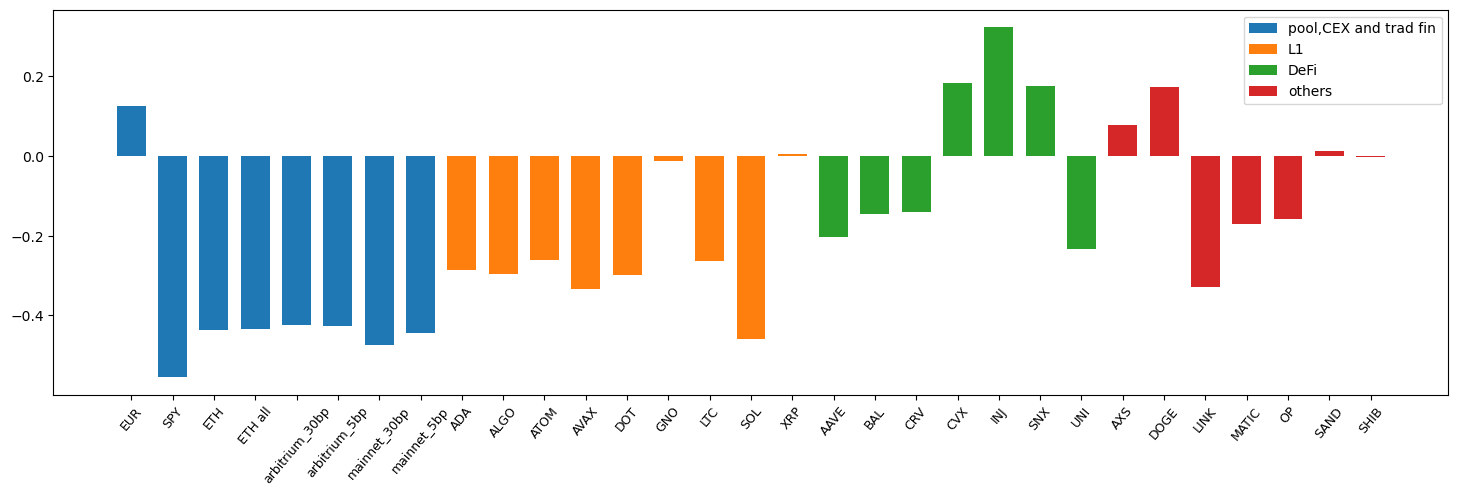

In [189]:
plt.figure(figsize=(18,5))
plt.tight_layout(pad=3.0)
pool_CEX_ =[]
for label in df_record.keys():
    if 'USDC' in label:
        label=label.replace(' USDC','')
    pool_CEX_.append(label)
plt.bar(pool_CEX_, df_record.values(), width=0.7, label="pool,CEX and trad fin")
plt.bar(df_group1_record.keys(), df_group1_record.values(), width=0.7, label="L1")
plt.bar(df_group2_record.keys(), df_group2_record.values(), width=0.7, label="DeFi")
plt.bar(df_group3_record.keys(), df_group3_record.values(), width=0.7, label="others")
plt.xticks(rotation=50,size=9)
plt.legend()
pass

# Time Reversal Asymmetry

TRA

Time period: 2021-09-23 - 2023-10-18

We calculate the time reversal asymmetry over a period as follows:

Correlation Calculations:

For each day \( d \) in the specified range \( \text{days} \), we compute:
$$
\text{corr}_d^+ = \text{corr}(\lvert R_{i+d} \rvert, \sigma_{rD})
$$

$$
\text{corr}_d^- = \text{corr}(\lvert R_{i-d} \rvert, \sigma_{rD})
$$

Cumulative Sum of Differences:
$$
\text{CumulativeSum}(d) = \sum_{i=1}^{d} \left( \text{corr}_i^- - \text{corr}_i^+ \right)
$$


##Function implementation

In [191]:
def time_rev_day(spx,dT='60min',days=np.arange(1,22)):
    a =  spx[spx['dT']==dT].copy()
    a["Date"] = pd.to_datetime(a["close_time"])
    a['day'] = a['Date'].dt.date
    a["log_close"] = a["close"].apply(np.log)
    a['rD'] = a.groupby('day')['log_close'].diff()
    b = pd.DataFrame(a.groupby('day')['rD'].std())
    b['open'] = a.groupby('day')['open'].first().to_numpy()
    b['close'] = a.groupby('day')['close'].last().to_numpy()
    b['R'] = np.log(b['close'])-np.log(b['open'])
    b['S'] = b['rD']-np.mean(b['rD'])
    c_mat = np.zeros([len(days),2])
    for d in days:
        tb = b.copy()
        #tb= b
        tb['h'] = tb['R'].shift(d)
        tb['f'] = tb['R'].shift(-d)
        tb = tb.dropna()
        c_mat[d-1,0] = np.corrcoef(np.abs(tb['h']),tb['rD'])[0,1]
        c_mat[d-1,1] = np.corrcoef(np.abs(tb['f']),tb['rD'])[0,1]
    return c_mat


def time_rev_day_5min(spx,dT='5min',days=np.arange(1,22)):
    a =  spx[spx['dT']==dT].copy()
    a["Date"] = pd.to_datetime(a["close_time"])
    a['hour'] = a['Date'].dt.floor('H')
    a['log_close'] = a['close'].apply(np.log)
    a['rH'] = a.groupby('hour')['log_close'].diff()
    b = pd.DataFrame(a.groupby('hour')['rH'].std())
    b.columns = ["std"]
    b['open'] = a.groupby('hour')['open'].first().to_numpy()
    b['close'] = a.groupby('hour')['close'].last().to_numpy()
    b['R'] = np.log(b['close']) - np.log(b['open'])

    c_mat = np.zeros([len(days),2])
    for d in days:
        tb = b[['R', 'std']].copy()
        tb['h'] = tb['R'].shift(d)
        tb['f'] = tb['R'].shift(-d)

        tb = tb.dropna()
        c_mat[d-1,0] = np.corrcoef(np.abs(tb['h']),tb['std'])[0,1]
        c_mat[d-1,1] = np.corrcoef(np.abs(tb['f']),tb['std'])[0,1]
    return c_mat


colors = ["#000000", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#ff6347", "#8a2be2", "#006400", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#ff1493", "#ffd700", "#00ff00", "#ff4500", "#00ced1", "#ff00ff", "#0000ff", "#ff69b4", "#556b2f", "#8b0000", "#ff8c00", "#b22222", "#4b0082", "#2e8b57", "#800080", "#5f9ea0", "#8b4513", "#483d8b", "#7cfc00", "#ffdead", "#b8860b", "#d2691e", "#00008b", "#32cd32", "#c71585", "#191970", "#808000"]
colorGen = itertools.cycle(colors)

## Time reversal asymmetry for hour period

In [203]:
df_5min_others.label.unique()

array(['arb_3000  WETH & USDC', 'arb_3000  WETH & DAI',
       'arb_500  WETH & USDC', 'arb_500  WETH & USDT',
       'm_3000  WETH & USDC', 'm_3000  WETH & DAI', 'm_500  WETH & USDC',
       'Binance  ETH & USD', 'Binance all  ETH & USD',
       'Binance  BTC & USD'], dtype=object)

In [193]:
c_spy_5min = time_rev_day_5min(df_spy_eur[df_spy_eur["label"] == "SPY"],dT='5min',days=np.arange(1,20))
c_eur_5min = time_rev_day_5min(df_spy_eur[df_spy_eur["label"] == "EUR"],dT='5min',days=np.arange(1,20))

# Why Hourly TRA?

(-0.2, 0.9)

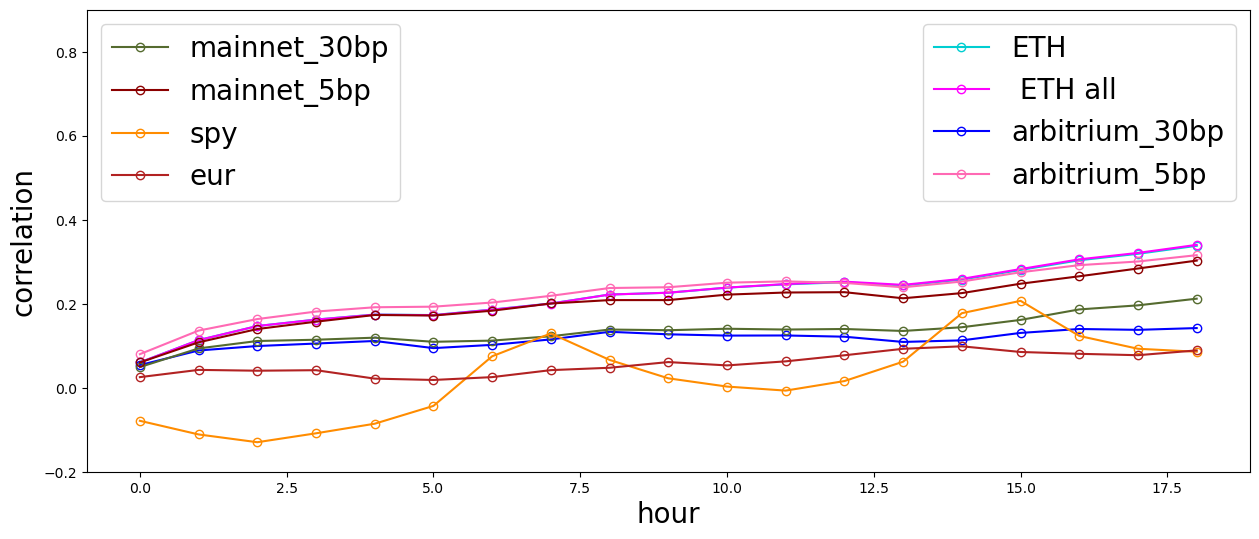

In [249]:
fig,ax = plt.subplots(figsize=(15,6))
df_all_hour = dict()
for name, group in df_5min_others.groupby(["label"]):
    if any( s in name[0] for s in ['DAI','USDT','BTC']):
        continue
    if 'Binance' in name[0]:
        label =_(name[0].replace(' & USD','').replace('Binance ',''))
    else:
        label = label_dict[name[0].replace('  WETH & USDC','')]
    group["open"] = group["close"]
    data = time_rev_day_5min(group,dT='5min',days=np.arange(1,20))
    df_all_hour[" ".join(name)] = np.cumsum(data.T[0] - data.T[1])[-1]
    ax.plot(np.cumsum(data.T[0] - data.T[1]),linestyle='-',marker='o',markerfacecolor='none',label=label, color=next(colorGen))

ax.plot(np.cumsum(c_spy_5min.T[0] - c_spy_5min.T[1]),linestyle='-',marker='o',markerfacecolor='none',label="spy", color=next(colorGen))
ax.plot(np.cumsum(c_eur_5min.T[0] - c_eur_5min.T[1]),linestyle='-',marker='o',markerfacecolor='none',label="eur", color=next(colorGen))

handles, labels = ax.get_legend_handles_labels()
n = len(handles)
first_legend = ax.legend(handles=[ handles[i] for i in range( int(n/2) ) ], loc = 1,fontsize = 20)
ax.add_artist(first_legend)
ax.legend(handles=[ handles[i] for i in np.arange(int(n/2),n ) ] ,loc=2,fontsize = 20)
    
ax.set_xlabel("hour",fontsize=20)
ax.set_ylabel("cumulative sum",fontsize=20)
ax.set_ylim(-0.2,0.9)

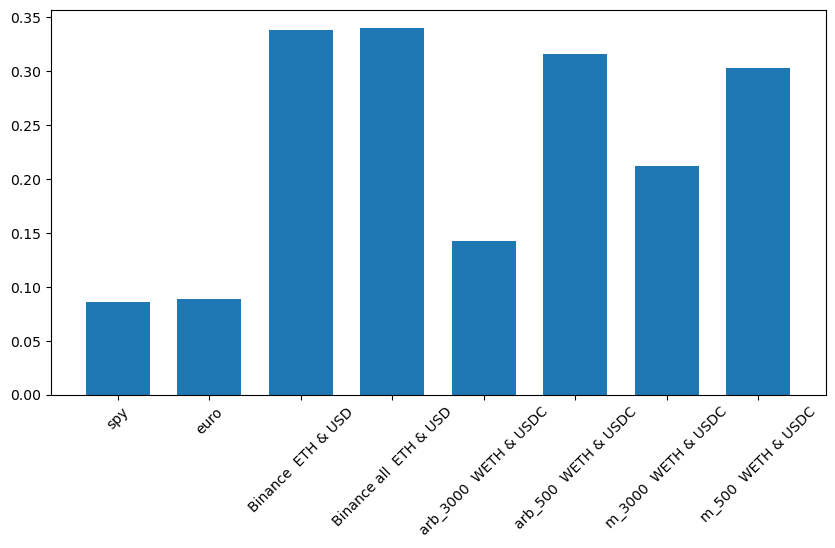

In [245]:
plt.figure(figsize=(10,5))
plt.tight_layout(pad=3.0)
keys = ["spy","eur", *df_all_hour.keys()]
values = [np.sum(c_spy_5min.T[0] - c_spy_5min.T[1]), np.sum(c_eur_5min.T[0] - c_eur_5min.T[1]), *df_all_hour.values()]
plt.bar(keys, values, width=0.7)
plt.xticks(rotation=45)
pass

##Time reversal asymmetry for day period

In [253]:
c_spy = time_rev_day(df_spy_eur[df_spy_eur["label"] == "SPY"],dT='1H',days=np.arange(1,20))
c_eur = time_rev_day(df_spy_eur[df_spy_eur["label"] == "EUR"],dT='1H',days=np.arange(1,20))

Text(150.09722222222223, 0.5, 'difference of corr with positive and negative delay')

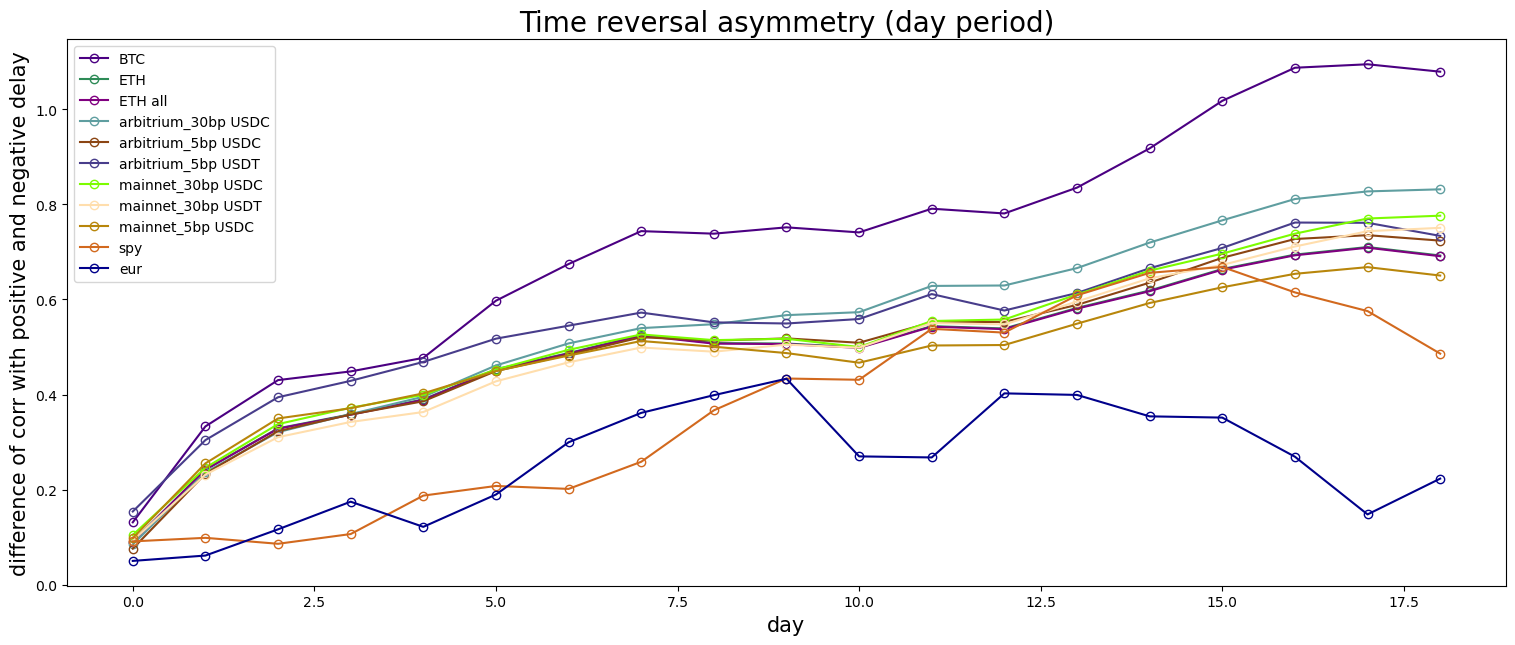

In [257]:
plt.figure(figsize=(15,6))
df_coin_records = dict()
for name, group in df_coin.groupby(["label"]):
    if name[0] in ["Binance all"] or "DAI" in name[0]:
        continue
    group["open"] = group["close"]
    data = time_rev_day(group,dT='1H',days=np.arange(1,20))
    df_coin_records[" ".join(name)] = np.cumsum(data.T[0] - data.T[1])[-1]

    plt.plot(np.cumsum(data.T[0] - data.T[1]),linestyle='-',marker='o',markerfacecolor='none',label=f"{name[0]}", color=next(colorGen))

plt.plot(np.cumsum(c_spy.T[0] - c_spy.T[1]),linestyle='-',marker='o',markerfacecolor='none',label="spy", color=next(colorGen))
plt.plot(np.cumsum(c_eur.T[0] - c_eur.T[1]),linestyle='-',marker='o',markerfacecolor='none',label="eur", color=next(colorGen))

legend = plt.legend()
plt.tight_layout()
plt.title("Time reversal asymmetry (day period)", fontsize=20)
plt.xlabel("day",fontsize=15)
plt.ylabel("difference of corr with positive and negative delay",fontsize=15)

In [258]:
df_group1 = df_others[df_others["label"].str.contains("|".join(L1))]
df_group2 = df_others[df_others["label"].str.contains("|".join(DeFi))]
df_group3 = df_others[df_others["label"].str.contains("|".join([*L2, *Oracle, *Gaming, *Shitcoin]))]

In [259]:
def TRA_plott(df, addition=""):
    plt.figure(figsize=(15,6))
    df_record = dict()
    for name, group in df.groupby("label"):
        if "INJ" in name:
            continue
        group["open"] = group["close"]
        data = time_rev_day(group,dT='1H',days=np.arange(1,20))
        df_record[name] = np.sum(data.T[0] - data.T[1])
        plt.plot(np.cumsum(data.T[0] - data.T[1]),linestyle='-',marker='o',markerfacecolor='none',label=f"{name}", color=next(colorGen))

    # plt.plot(np.cumsum(c_spy.T[0] - c_spy.T[1]),linestyle='-',marker='o',markerfacecolor='none',label="spy", color=next(colorGen))
    # plt.plot(np.cumsum(c_eur.T[0] - c_eur.T[1]),linestyle='-',marker='o',markerfacecolor='none',label="eur", color=next(colorGen))
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.title("Time reversal asymmetry (day period) " + addition, fontsize=20)
    plt.xlabel("day",fontsize=15)
    plt.ylabel("difference of corr with positive delay and negative delay",fontsize=15)
    return df_record

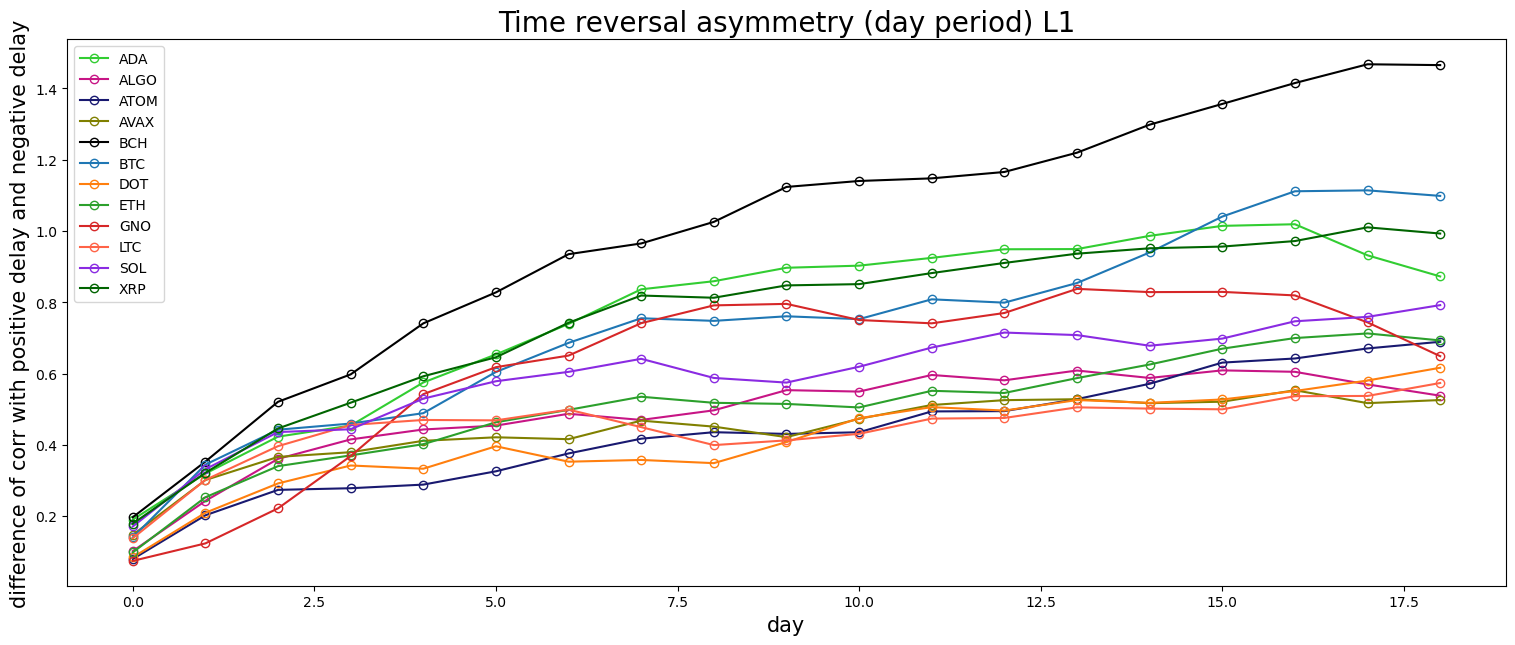

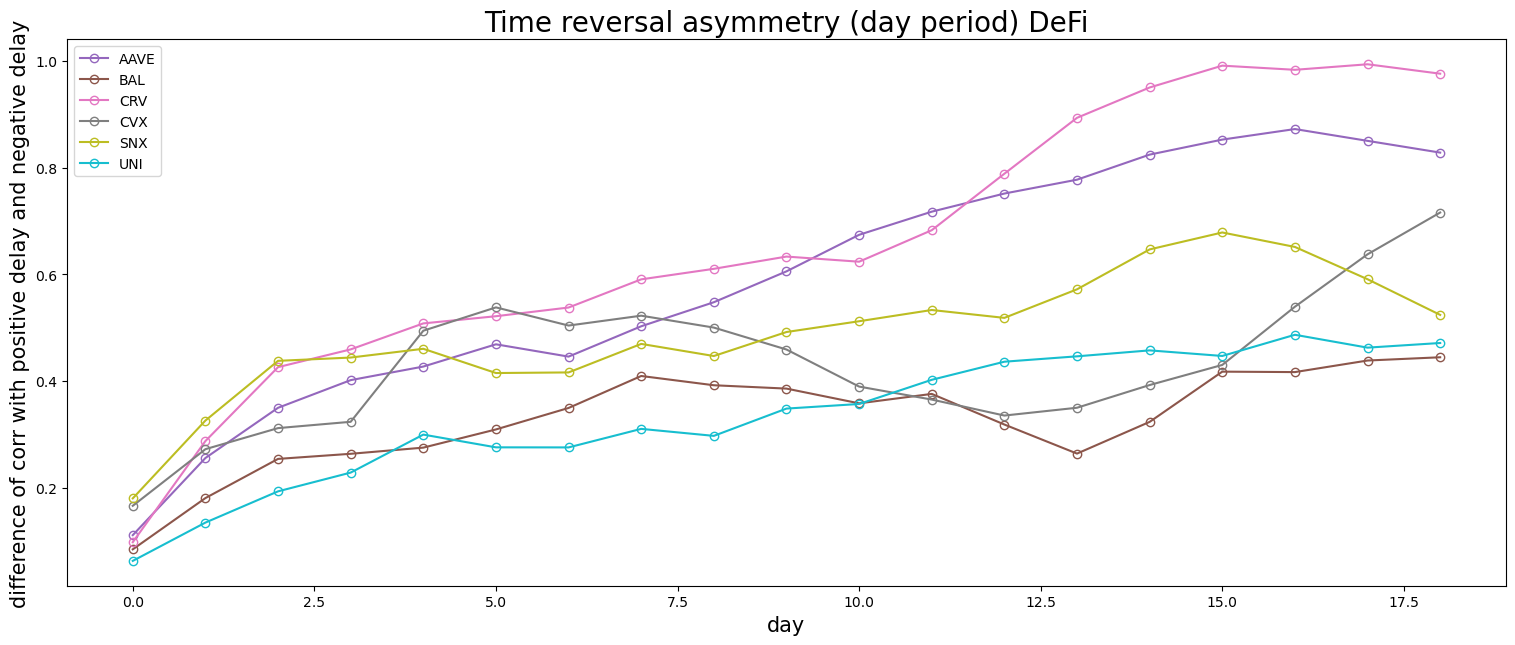

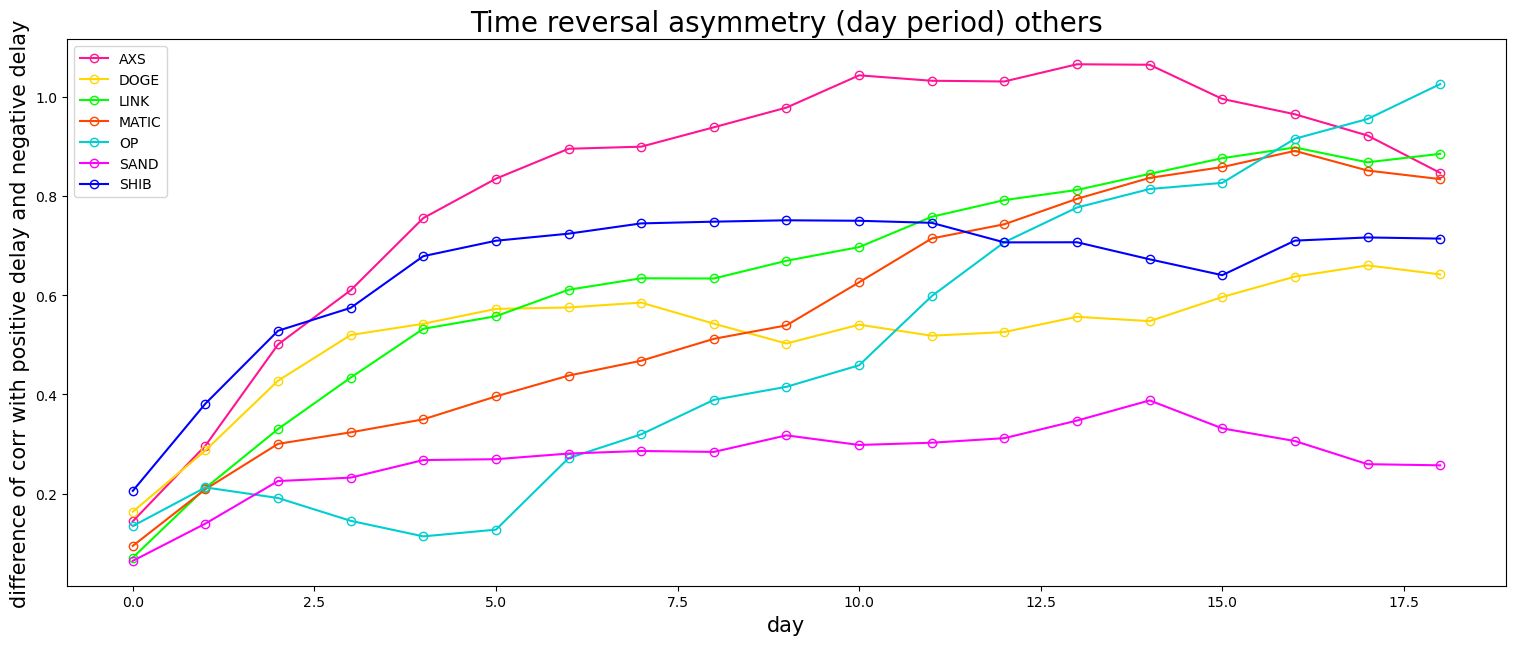

In [260]:
df_group1_record = TRA_plott(df_group1,addition="L1")
df_group2_record = TRA_plott(df_group2,addition="DeFi")
df_group3_record = TRA_plott(df_group3,addition="others")

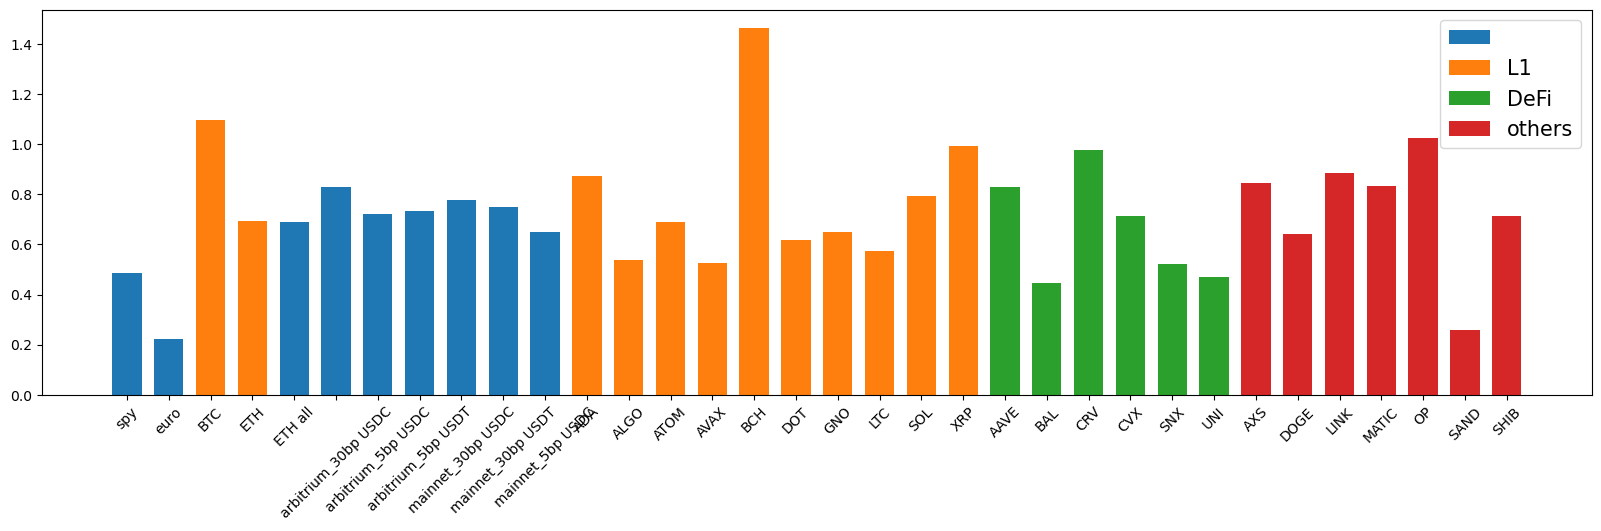

In [261]:
plt.figure(figsize=(20,5))
plt.tight_layout(pad=3.0)
keys = ["spy","euro", *df_coin_records.keys()]
values = [np.sum(c_spy.T[0] - c_spy.T[1]), np.sum(c_eur.T[0] - c_eur.T[1]), *df_coin_records.values()]
plt.bar(keys, values, width=0.7, label=" ")
plt.bar(df_group1_record.keys(), df_group1_record.values(), width=0.7, label="L1")
plt.bar(df_group2_record.keys(), df_group2_record.values(), width=0.7, label="DeFi")
plt.bar(df_group3_record.keys(), df_group3_record.values(), width=0.7, label="others")
plt.xticks(rotation=45)
plt.legend(fontsize=15)
pass